- 300 mV

In [1]:
import importlib

import all_funcs
importlib.reload(all_funcs)
from all_funcs import *


##### Raw data
- need to work out mean and sd noise

In [3]:
base_path_DNA= "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/10kb_DNA/"
file_template_DNA = "10kb_200pM_1MKCl_1_{}.abf"
paths_DNA = [base_path_DNA + file_template_DNA.format(str(i).zfill(4)) for i in range(6, 22)]


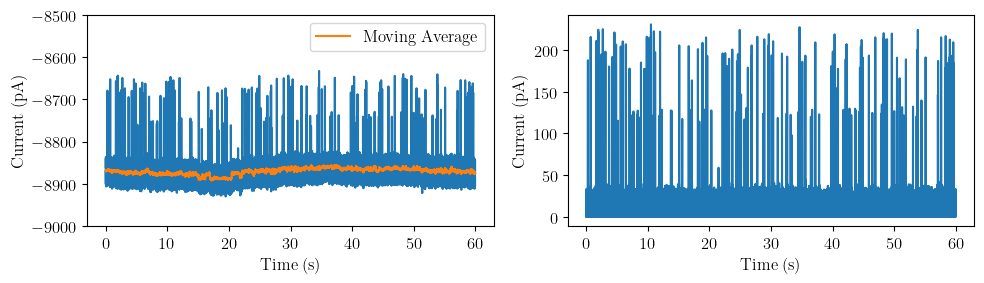

In [4]:
x_10kb_0006, y_10kb_0006, sma_10kb_0006, y_corrected_10kb_0006, y_base_10kb_0006, x_base_10kb_0006 = importABF_movingavg(paths_DNA[0], resistive = False)    

plot_baseline_correct(x_10kb_0006, y_10kb_0006, sma_10kb_0006, y_corrected_10kb_0006, y_base_10kb_0006, x_base_10kb_0006, ylim = [-9000, -8500])



In [5]:
threshold_10kb_0006, mean_noise_10kb_0006, sd_noise_10kb_0006 = define_threshold(y_base_10kb_0006, 12)
threshold_10kb_0006, mean_noise_10kb_0006, sd_noise_10kb_0006

(79.2925588142403, 3.835250170134017, 6.288109053675523)

##### events only MAT

In [6]:
counts_df = pd.read_csv('10_kbps_DNA_counts_extract.csv', header=None)
time_df = pd.read_csv('10_kbps_DNA_event_time.csv', header=None)
event_base_df = pd.read_csv('event_base_full.csv', header=None)

In [7]:
def split_at_nan(df):
    # Convert dataframe to a 1D numpy array
    data_array = df.to_numpy().flatten()
    # Find the indices of NaN values
    nan_indices = np.flatnonzero(np.isnan(data_array))
    # Add the start and end indices
    nan_indices = np.insert(nan_indices, 0, -1)  # Start from index 0
    nan_indices = np.append(nan_indices, len(data_array))  # End at the last index
    # Split the data_array at the NaN indices
    return [data_array[(nan_indices[i]+1):nan_indices[i+1]] for i in range(len(nan_indices)-1)]

counts_list = split_at_nan(counts_df)
counts_list = [i * 1000 for i in counts_list] # converting to pA
counts_list.remove(counts_list[-1]) # removing final NAN
time_list = split_at_nan(time_df)
time_list.remove(time_list[-1])

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_11012/3788695958.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  counts_list.remove(counts_list[-1]) # removing final NAN
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_11012/3788695958.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  time_list.remove(time_list[-1])


In [8]:
time_flat = [item for sublist in time_list for item in sublist]
counts_flat = [item for sublist in counts_list for item in sublist]

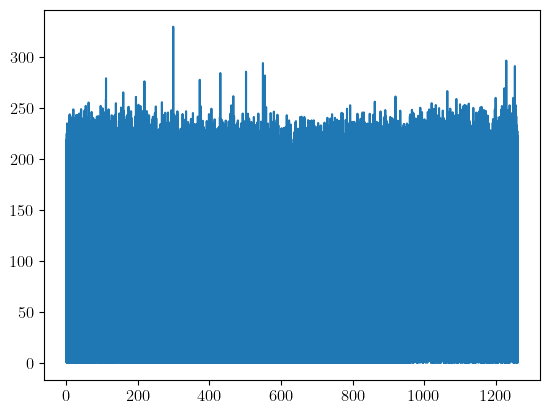

In [67]:
plt.plot(time_flat, counts_flat)

In [68]:
max_count = 0
for i in counts_list:
    if len(i) > max_count:
        max_count = len(i)
        idx_max = counts_list.index(i)
max_count, idx_max

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_29524/2091133041.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  idx_max = counts_list.index(i)


(501, 850)

In [10]:
# extraction from MATLAB

# event_time = {};
# for i = 1:length(Event)
#     % Append the data with a NaN to signify the end of an event
#     event_time{end+1} = [Event{i}.TimeExtract; NaN];
# end
# % Flatten the cell arrays to matrices
# eventMatrix = cell2mat(event_time');

# % Write the matrices to CSV files with higher precision
# dlmwrite('event_time_10kbs.csv', eventMatrix, 'precision', '%.15f');


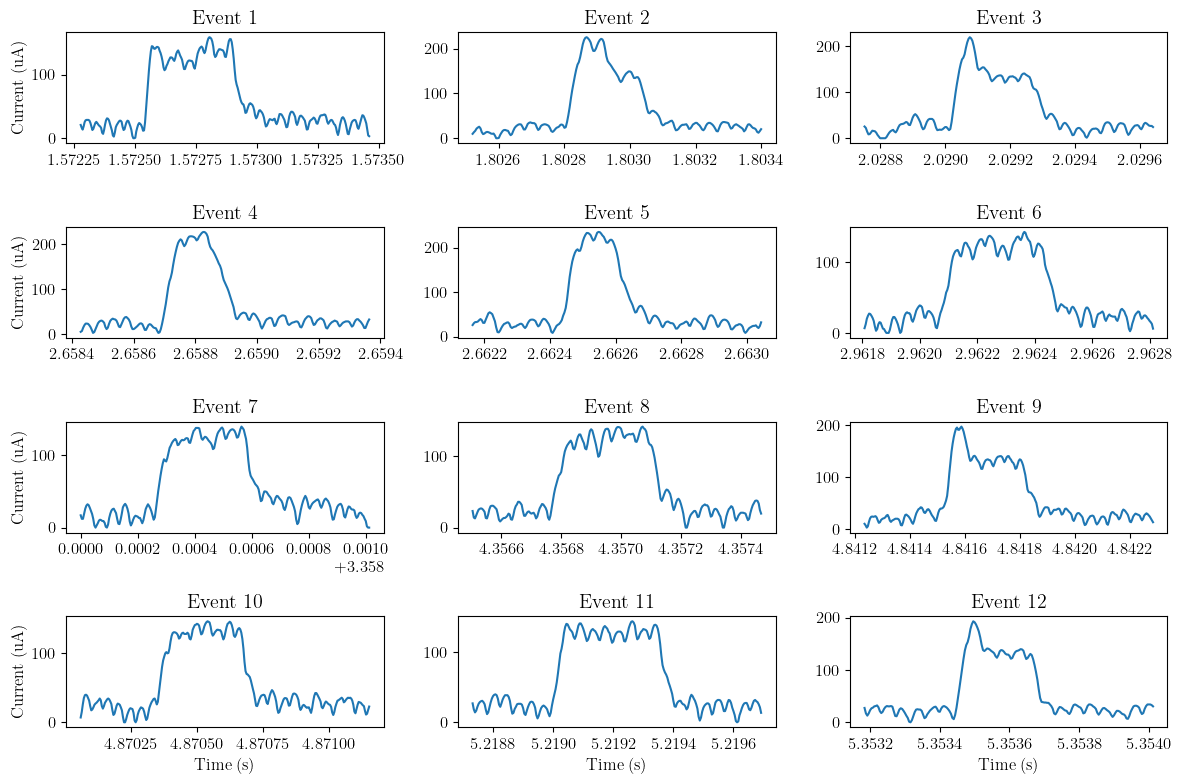

In [69]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))
axs = axs.flatten()

for i, ax in zip(range(12), axs):

    ax.plot(time_list[i], counts_list[i])
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (uA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    #ax.set_ylim(-30, 60)

plt.tight_layout()
plt.show()

##### Capture rate

In [103]:
times_between_event_only = []
times_between_event_only = time_between_events(time_list)
times_between_event_only = np.array(times_between_event_only)

In [105]:
def model(t, r1, r2):
    return r1 * np.exp(-r2 * t)

errors 5 nm [2.4049 0.0302]


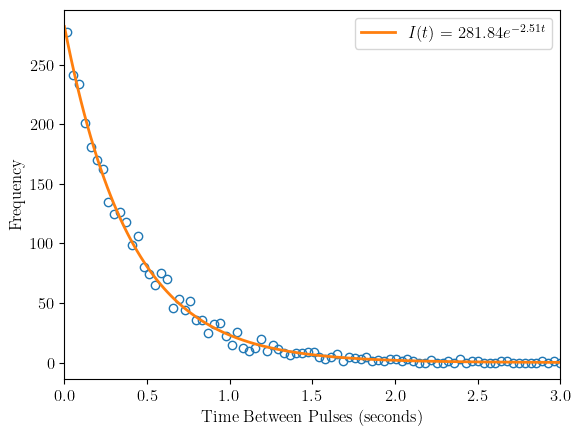

In [114]:
no_bins = 100
counts, bin_edges = np.histogram(times_between_event_only, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_5, cov_5 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
errors_5 = np.sqrt(np.diag(cov_5))
print("errors 5 nm", errors_5)

plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_5), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_5[0]:.2f}$e^{{-{params_5[1]:.2f}t}}$')
plt.xlim(0, 3)
plt.xlabel('Time Between Pulses (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##### New features

In [205]:
def find_features_CWT(event_time, event_data, mean_noise, coeffs, upper_threshold, lower_threshold = -np.inf, small_resistive = False, whole_run = False, DNA = False):

    #features_dic = {"deltaI_c": [], "deltaI_r": [], "deltaI_c/deltaI_r": [], "dwell_time": [], "skew": [], "kurtosis": [], "total_area": [], "conductive_area": [], "resistive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": [], "decay_time_lhs": [], "decay_time_rhs": []}
    #features_dic = {"deltaI_c": [], "deltaI_r": [], "deltaI_c/deltaI_r": [], "dwell_time": [], "skew": [], "kurtosis": [], "total_area": [], "conductive_area": [], "resistive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": []}
    features_dic = {"deltaI_c": [], "deltaI_r": [], "deltaI_c/deltaI_r": [], "dwell_time": [], "skew": [], "kurtosis": [], "total_area": [], "conductive_area": [], "resistive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": [], "decay_time_lhs": [], "decay_time_rhs": [], "approx_mean": [], "approx_sd": [], "approx_energy": [], "spectral_entropy": [], "band_power": []}
    
    count = 0
    
    for event, time in zip(event_data, event_time):
        event_type = None
            
        # classify event as just conductive or conductive and resistive
        if small_resistive:
            event_type = "trough-peak"
            
        elif DNA:
            event_type = "peak-only"
            
        else:
            for i in range(len(event)):
                # Check for a trough-peak pattern
                #if event[i] < lower_threshold:
                if event[i] < -20 or event[i] < lower_threshold:
                    event_type = "trough-peak"
                    break
                # Check for a peak-only pattern
                elif event[i] > upper_threshold:
                    event_type = "peak-only"
                    break
            

    
        if whole_run:
            features_dic = {"deltaI_c": [], "deltaI_r": [], "deltaI_c/deltaI_r": [], "dwell_time": [], "skew": [], "kurtosis": [], "total_area": [], "conductive_area": [], "resistive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": [], "decay_time_lhs": [], "decay_time_rhs": []}
        
        if DNA: 
            features_dic = {"deltaI_c": [], "dwell_time": [], "skew": [], "kurtosis": [], "conductive_area": [], "no_peaks":[], "peak_lower_delta_I":[], "peak_pos_rel":[], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": [], "decay_time_lhs": [], "decay_time_rhs": [], "approx_mean": [], "approx_sd": [], "approx_energy": [], "spectral_entropy": [], "band_power": []}

        else:
            features_list_approx = coeff_features(coeffs[count][0])
            features_dic["approx_mean"].append(features_list_approx[0])
            features_dic["approx_sd"].append(features_list_approx[1])
            features_dic["approx_energy"].append(features_list_approx[2])
            features_dic["spectral_entropy"].append(features_list_approx[3])
            features_dic["band_power"].append(features_list_approx[4])
            count += 1
        # coeff_dic = coeff_features_dict(features_list_approx, features_list_detail)
        # for key in coeff_dic:
        #     features_dic[key + "_mean"] = coeff_dic[key][0]
        #     features_dic[key + "_sd"] = coeff_dic[key][1]
        #     features_dic[key + "_energy"] = coeff_dic[key][2]
        #     features_dic[key + "_max"] = coeff_dic[key][3]
        #     features_dic[key + "_min"] = coeff_dic[key][4]
        
        dwell_time = find_dwell_time_FWHM(time, event, event_type)
        features_dic["dwell_time"].append(dwell_time)
        
        decay_time_lhs, decay_time_rhs = decay_const(time, event, DNA = DNA)
        features_dic["decay_time_lhs"].append(decay_time_lhs)
        features_dic["decay_time_rhs"].append(decay_time_rhs)
        
        conductive_area, resistive_area = resistive_conductive_area(time, event, event_type)
        features_dic["conductive_area"].append(conductive_area)
        if not DNA:
            features_dic["resistive_area"].append(resistive_area)
        
        max_derivative, min_derivative, sum_abs_changes, sign_change_sum = derivative_features(time, event)
        features_dic["max_deriv"].append(max_derivative)
        features_dic["min_deriv"].append(min_derivative)
        features_dic["sum_absolute_changes"].append(sum_abs_changes)
        features_dic["sign_changes_sum"].append(sign_change_sum)
        
        deltaI_c = max(event) - mean_noise
        deltaI_r = min(event) - mean_noise
        deltaI_ratio = abs(deltaI_c / deltaI_r) if deltaI_r != 0 else 0
        features_dic["deltaI_c"].append(deltaI_c) 
        if not DNA:
            features_dic["deltaI_r"].append(deltaI_r)
            features_dic["deltaI_c/deltaI_r"].append(deltaI_ratio)
            
        if DNA:
            no_peaks, peak_pos_rel, peak_max_idx, peak_lower_idx = find_no_peaks_DNA(event, sd_threshold)
            
            features_dic["no_peaks"].append(no_peaks)
            features_dic["peak_pos_rel"].append(peak_pos_rel)
            features_dic["peak_lower_delta_I"].append(event[peak_lower_idx])
            
            
        entropy = calculate_entropy(event)
        features_dic["entropy"].append(entropy) 
        
        features_dic["mean"].append(np.nanmean(event))
        features_dic["std"].append(np.nanstd(event))
        features_dic["var"].append(np.nanvar(event))
        features_dic["rms"].append(np.nanmean(np.sqrt(event**2)))
        
        features_dic["skew"].append(skew(event) if DNA else 0) 
        features_dic["kurtosis"].append(kurtosis(event)if DNA else 0) 
        if not DNA:
            features_dic["total_area"].append(np.trapz(event, time))

        # features_dic["skew"].append(skew(event) if event_type == "peak-only" else 0) 
        # features_dic["kurtosis"].append(kurtosis(event) if event_type == "peak-only" else 0) 
        # features_dic["area"].append(np.trapz(event, time) if event_type == "peak-only" else 0)
        
        df = pd.DataFrame(features_dic)
        
        features_list = []
        for i in range(len(df)): 
            # i for a df is deltaI_c, deltaI_r...
            features_list.append(list(df.iloc[i]))
                
    return df, features_list


In [243]:
decay_const(time_list[0], counts_list[0], DNA=True)

(9.199999999998099e-05, 0.00013199999999979894)

In [134]:
peaks, _ = find_peaks(DWT_rec_test[2], height=80, distance=20)
peaks

array([ 81, 121])

In [162]:
DWT_rec_test[idx_test][peak_max+30:]

array([124.0596, 124.8459, 125.7409, ...,  22.9594,  22.2962,  21.2761])

In [163]:
DWT_rec_test[idx_test][peak_max-30]

30.649748325789815

In [168]:
DWT_rec_test[idx_test][peaks_lower]

array([11.7521])

In [170]:
peaks_lower

array([11])

In [209]:
def find_no_peaks_DNA(event, sd_threshold):
    peak_max = np.argmax(event)
    peaks_lower, _ = find_peaks(event[peak_max+20:], height=(sd_threshold, event[peak_max] - 20), distance=50, prominence=0.5)
    
    peak_lower_idx = peaks_lower[0] + peak_max + 20
    
    if peaks_lower.size > 0:
        no_peaks = 2
    else:
        no_peaks = 1
        
    peak_pos_rel = peak_max / len(event)
    
    return no_peaks, peak_pos_rel, peak_max, peak_lower_idx
    

In [199]:
peaks_lower[0]

30

81 [21]


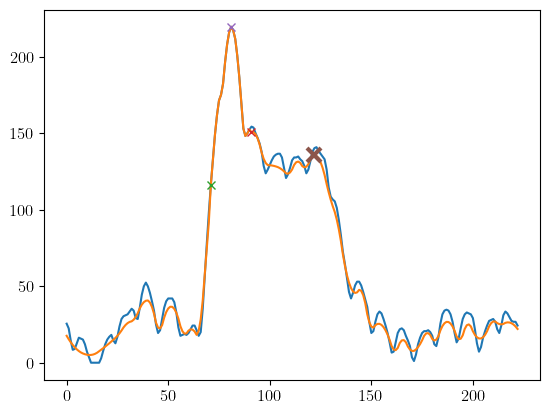

In [196]:
idx_test = 2
peak_max = np.argmax(DWT_rec_test[idx_test])
peaks_lower, _ = find_peaks(DWT_rec_test[idx_test][peak_max+20:], height=(threshold_10kb_0006, DWT_rec_test[idx_test][peak_max] - 20), distance=50, prominence=0.5)
print(peak_max, peaks_lower)
plt.plot(counts_list[idx_test])
plt.plot(DWT_rec_test[idx_test])
plt.plot(peak_max-10, DWT_rec_test[idx_test][peak_max-10], "x")
plt.plot(peak_max+10, DWT_rec_test[idx_test][peak_max+10], "x")


#plt.plot(peaks, DWT_rec_test[idx_test][peaks], "x")
plt.plot(peak_max, DWT_rec_test[idx_test][peak_max], "x")
if peaks_lower.size > 0:
    plt.plot(peaks_lower+peak_max+20, DWT_rec_test[idx_test][peaks_lower+peak_max+20], "x", markeredgewidth=3, markersize=10)

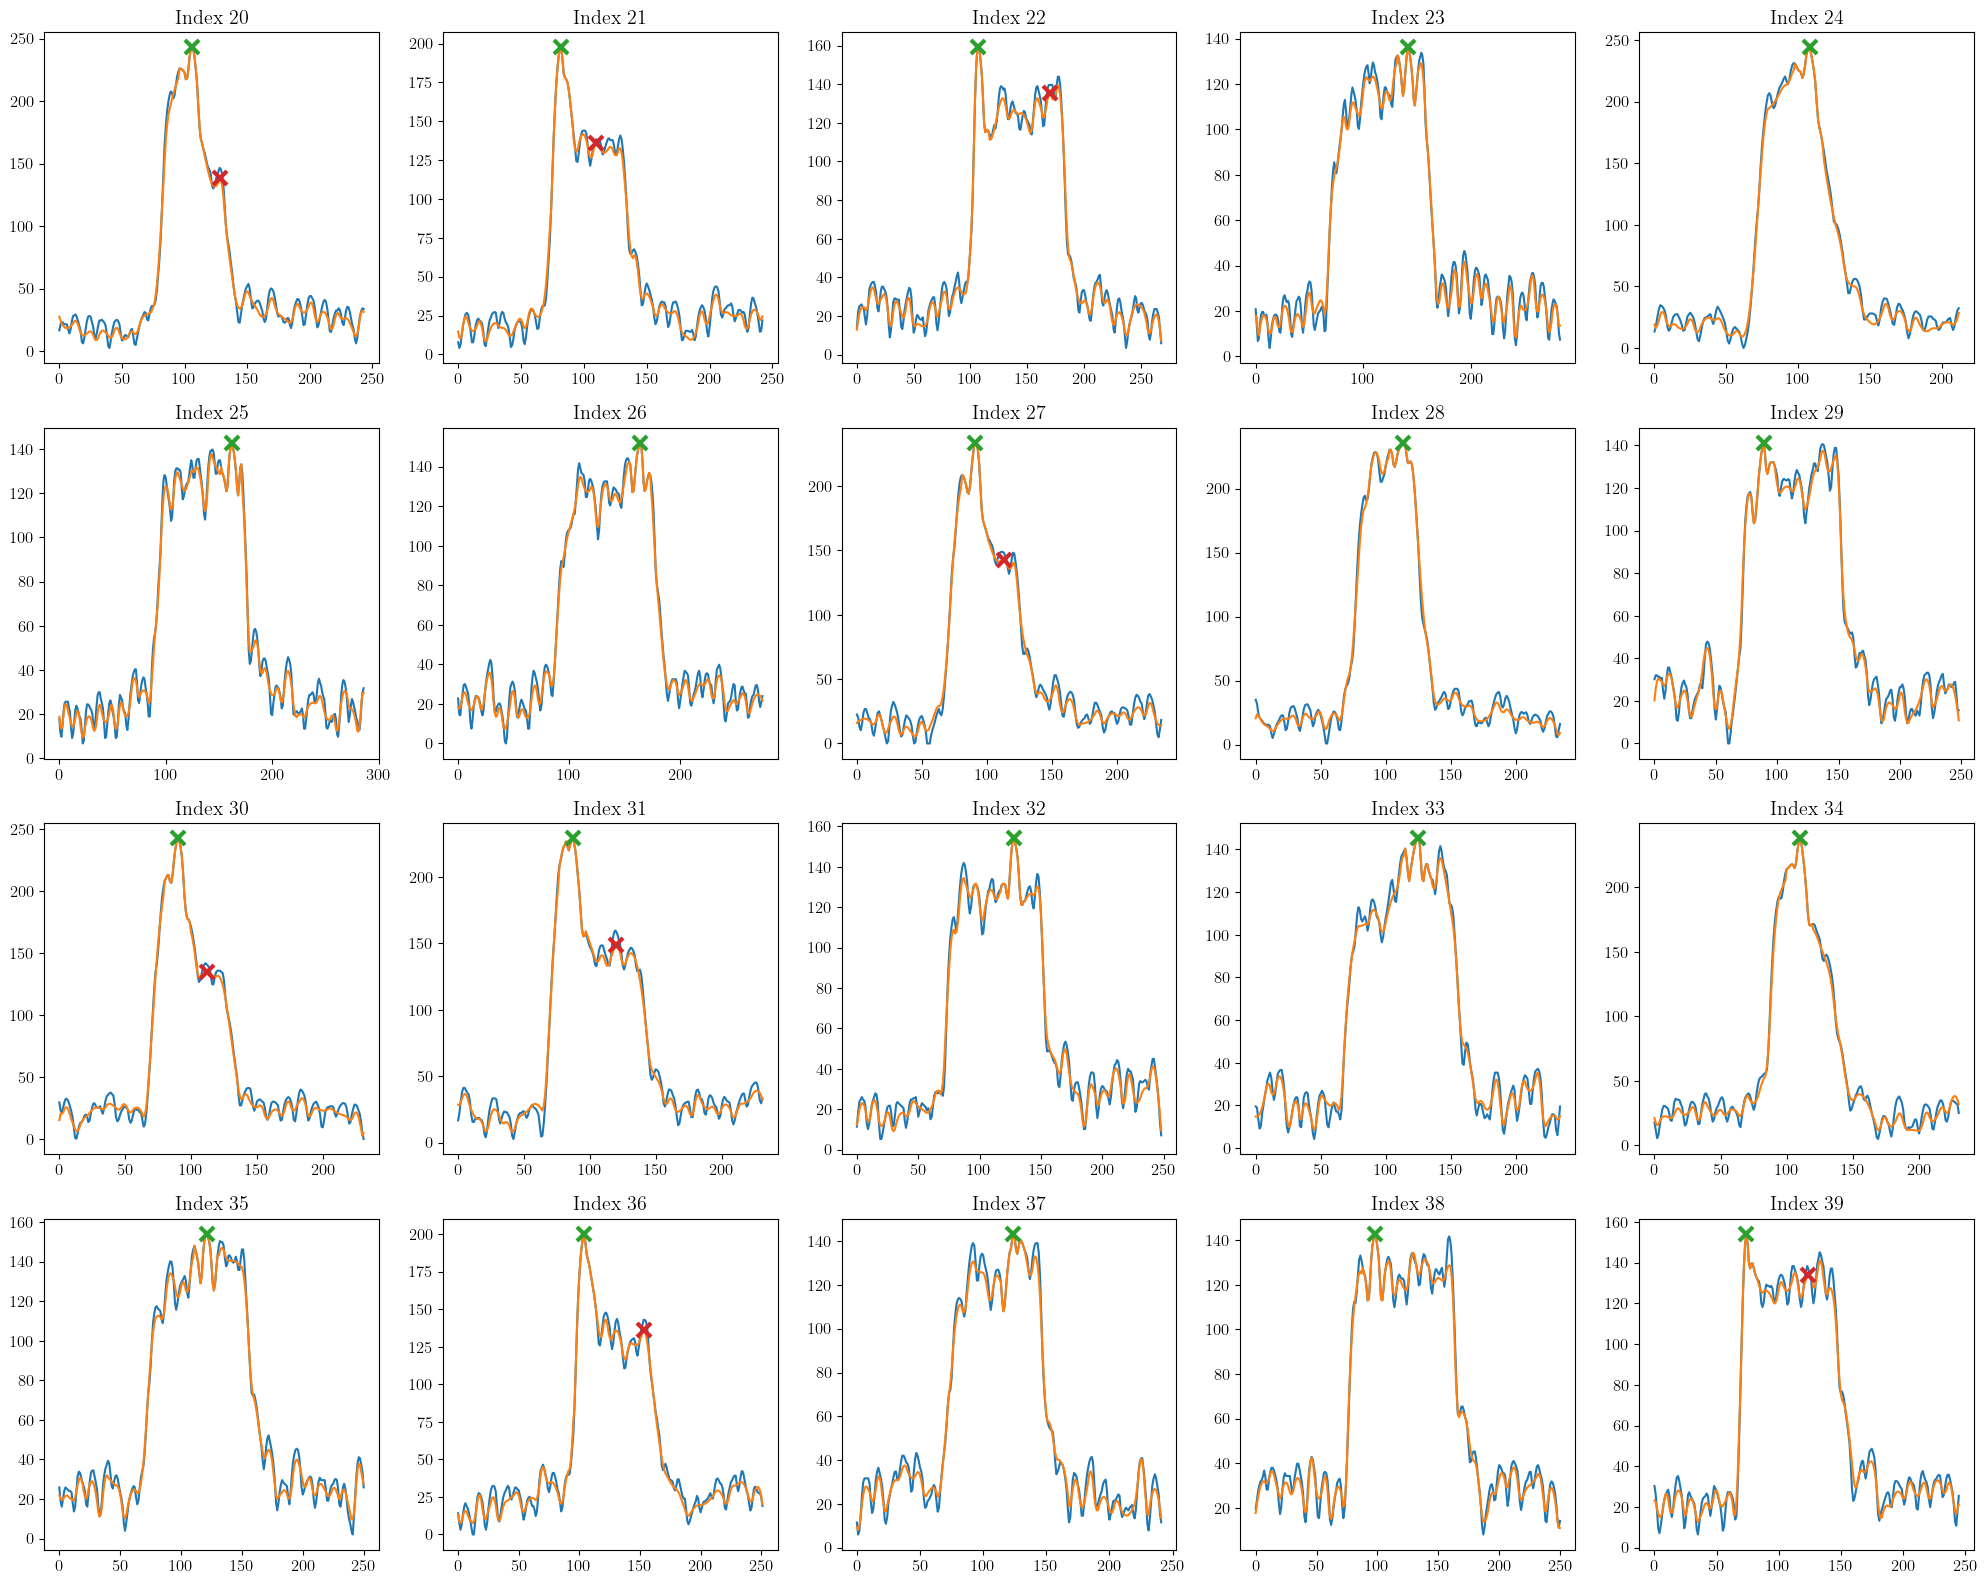

In [197]:
fig, axs = plt.subplots(4, 5, figsize=(20, 16))  # Adjust the figsize as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for idx, idx_test in enumerate(range(20, 40)):
    peak_max = np.argmax(DWT_rec_test[idx_test])
    peaks_lower, _ = find_peaks(DWT_rec_test[idx_test][peak_max+20:], height=(threshold_10kb_0006, DWT_rec_test[idx_test][peak_max] - 20), distance=50, prominence=0.5)
    
    # Plotting on the respective subplot
    axs[idx].plot(counts_list[idx_test], label=f'Counts List {idx_test}')
    axs[idx].plot(DWT_rec_test[idx_test], label=f'DWT Rec Test {idx_test}')
    axs[idx].plot(peak_max, DWT_rec_test[idx_test][peak_max], "x", label='Primary Peak', markersize=10, markeredgewidth=3)
    
    if peaks_lower.size > 0:
        axs[idx].plot(peaks_lower + peak_max + 20, DWT_rec_test[idx_test][peaks_lower + peak_max + 20], "x", markersize=10, markeredgewidth=3)
    
    axs[idx].set_title(f'Index {idx_test}')

plt.tight_layout()
plt.show()

##### DWT, padding and feature extraction

In [ ]:
time_list[i], counts_list[i]

In [19]:
def all_wavelets(event_times, event_datas, mean_noise, sd_threshold, threshold=0.1):
    wavelets = pywt.wavelist(kind='discrete')  # Use first 3 wavelets for testing
    df_list = []
    event_time_padded_dic = {}
    DWT_rec_padded_dic = {}
    features_dic = {wavelet: [] for wavelet in wavelets}  # Prepare dictionary for features

    for wavelet in wavelets:
        try:
            DWT_rec, event_time_padded, DWT_rec_padded, features_df, features_list, all_coeffs = DWT_and_features_thresh_trace_DNA(
                time_list, counts_list, 0, threshold_10kb_0006, None, wavelet = wavelet, threshold=threshold, tracing_thresh=160)
            

            
            # Store padded times and DWT reconstructions
            event_time_padded_dic[wavelet] = event_time_padded
            DWT_rec_padded_dic[wavelet] = DWT_rec_padded
            
            # Store features
            features_dic[wavelet].extend(features_list)

        except Exception as e:
            print(f"Error occurred for wavelet '{wavelet}': {e}")
            
    # Construct df_all_wavelets with wavelet names as columns, containing lists of features
    df_all_wavelets = pd.DataFrame({k: [v] for k, v in features_dic.items()})

    # Construct df_events_all_wavelets with wavelet names as columns
    # Each row under a wavelet contains event time padded and DWT rec padded, respectively
    df_events_all_wavelets = pd.DataFrame({
        'event_time_padded': {k: v for k, v in event_time_padded_dic.items()},
        'DWT_rec_padded': {k: v for k, v in DWT_rec_padded_dic.items()}
    })

    # Transpose df_events_all_wavelets to match desired format
    df_events_all_wavelets = df_events_all_wavelets.T

    return df_all_wavelets, df_events_all_wavelets


In [18]:

def DWT_and_features_thresh_trace_DNA(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower, wavelet, threshold, NRNS = False, tracing_thresh = None):
    """DWT_and_features with thresholding and peak tracing

    Args:
        event_time, event_data (list of arrays): event data for 1 run, containing all events 
        mean_noise, sd_threshold, sd_threshold_lower, NP_size, wavelet, threshold

    Returns:
        DWT_rec, event_time_padded, DWT_rec_padded, features_df, features_list, labels, all_coeffs
    """
    
    
    DWT_rec, all_coeffs = zip(*[lowpassfilter_all(signal, wavelet=wavelet, thresh = threshold) for signal in event_data])
    DWT_rec, all_coeffs = list(DWT_rec), list(all_coeffs)
    
    if tracing_thresh:
        DWT_rec = peak_tracer(event_data, DWT_rec, tracing_thresh, sd_threshold_lower, thresh = threshold, NRNS = NRNS)
    else:
        DWT_rec = peak_tracer(event_data, DWT_rec, sd_threshold, sd_threshold_lower, thresh = threshold, NRNS = NRNS)


    event_time_padded, DWT_rec_padded = pad_event(event_time, DWT_rec, mean_noise, custom_length=501)

    features_df, features_list = find_features_CWT(event_time_padded, DWT_rec_padded, mean_noise, all_coeffs, sd_threshold, 0, DNA = True)
    
    
    return DWT_rec, event_time_padded, DWT_rec_padded, features_df, features_list, all_coeffs


In [ ]:
def find_features_CWT(event_time, event_data, mean_noise, coeffs, upper_threshold, lower_threshold = -np.inf, small_resistive = False, whole_run = False, DNA = False):

    #features_dic = {"deltaI_c": [], "deltaI_r": [], "deltaI_c/deltaI_r": [], "dwell_time": [], "skew": [], "kurtosis": [], "total_area": [], "conductive_area": [], "resistive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": [], "decay_time_lhs": [], "decay_time_rhs": []}
    #features_dic = {"deltaI_c": [], "deltaI_r": [], "deltaI_c/deltaI_r": [], "dwell_time": [], "skew": [], "kurtosis": [], "total_area": [], "conductive_area": [], "resistive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": []}
    features_dic = {"deltaI_c": [], "deltaI_r": [], "deltaI_c/deltaI_r": [], "dwell_time": [], "skew": [], "kurtosis": [], "total_area": [], "conductive_area": [], "resistive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": [], "decay_time_lhs": [], "decay_time_rhs": [], "approx_mean": [], "approx_sd": [], "approx_energy": [], "spectral_entropy": [], "band_power": []}
    
    count = 0
    
    for event, time in zip(event_data, event_time):
        event_type = None
            
        # classify event as just conductive or conductive and resistive
        if small_resistive:
            event_type = "trough-peak"
        elif DNA:
            event_type = "peak-only"
            features_dic = {"deltaI_c": [], "dwell_time": [], "skew": [], "kurtosis": [], "conductive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": [], "decay_time_lhs": [], "decay_time_rhs": [], "approx_mean": [], "approx_sd": [], "approx_energy": [], "spectral_entropy": [], "band_power": []}

            
        else:
            for i in range(len(event)):
                # Check for a trough-peak pattern
                #if event[i] < lower_threshold:
                if event[i] < -20 or event[i] < lower_threshold:
                    event_type = "trough-peak"
                    break
                # Check for a peak-only pattern
                elif event[i] > upper_threshold:
                    event_type = "peak-only"
                    break
            

    
        if whole_run:
            features_dic = {"deltaI_c": [], "deltaI_r": [], "deltaI_c/deltaI_r": [], "dwell_time": [], "skew": [], "kurtosis": [], "total_area": [], "conductive_area": [], "resistive_area": [], "entropy": [], "mean": [], "std": [], "var": [], "rms": [], "max_deriv": [], "min_deriv": [], "sum_absolute_changes": [], "sign_changes_sum": [], "decay_time_lhs": [], "decay_time_rhs": []}
            
        else:
            features_list_approx = coeff_features(coeffs[count][0])
            features_dic["approx_mean"].append(features_list_approx[0])
            features_dic["approx_sd"].append(features_list_approx[1])
            features_dic["approx_energy"].append(features_list_approx[2])
            features_dic["spectral_entropy"].append(features_list_approx[3])
            features_dic["band_power"].append(features_list_approx[4])
            count += 1
        # coeff_dic = coeff_features_dict(features_list_approx, features_list_detail)
        # for key in coeff_dic:
        #     features_dic[key + "_mean"] = coeff_dic[key][0]
        #     features_dic[key + "_sd"] = coeff_dic[key][1]
        #     features_dic[key + "_energy"] = coeff_dic[key][2]
        #     features_dic[key + "_max"] = coeff_dic[key][3]
        #     features_dic[key + "_min"] = coeff_dic[key][4]
        
        dwell_time = find_dwell_time_FWHM(time, event, event_type)
        features_dic["dwell_time"].append(dwell_time)
        
        decay_time_lhs, decay_time_rhs = decay_const(time, event)
        features_dic["decay_time_lhs"].append(decay_time_lhs)
        features_dic["decay_time_rhs"].append(decay_time_rhs)
        
        conductive_area, resistive_area = resistive_conductive_area(time, event, event_type)
        features_dic["conductive_area"].append(conductive_area)
        features_dic["resistive_area"].append(resistive_area) if not DNA
        
        max_derivative, min_derivative, sum_abs_changes, sign_change_sum = derivative_features(time, event)
        features_dic["max_deriv"].append(max_derivative)
        features_dic["min_deriv"].append(min_derivative)
        features_dic["sum_absolute_changes"].append(sum_abs_changes)
        features_dic["sign_changes_sum"].append(sign_change_sum)
        
        deltaI_c = max(event) - mean_noise
        # deltaI_r = (min(event) - mean_noise) if (min(event) - mean_noise) < lower_threshold else 0
        # deltaI_ratio = deltaI_c / deltaI_r if deltaI_r != 0 else 0
        deltaI_r = min(event) - mean_noise
        deltaI_ratio = abs(deltaI_c / deltaI_r) if deltaI_r != 0 else 0
        features_dic["deltaI_c"].append(deltaI_c) 
        features_dic["deltaI_r"].append(deltaI_r) if not DNA
        features_dic["deltaI_c/deltaI_r"].append(deltaI_ratio) if not DNA
        
        entropy = calculate_entropy(event)
        features_dic["entropy"].append(entropy) 
        
        #features_dic["n5"].append(np.nanpercentile(event, 5))
        #features_dic["n25"].append(np.nanpercentile(event, 25))
        #features_dic["n75"].append(np.nanpercentile(event, 75))
        #features_dic["n95"].append(np.nanpercentile(event, 95))
        #features_dic["median"].append(np.nanpercentile(event, 50))
        features_dic["mean"].append(np.nanmean(event))
        features_dic["std"].append(np.nanstd(event))
        features_dic["var"].append(np.nanvar(event))
        features_dic["rms"].append(np.nanmean(np.sqrt(event**2)))
        
        features_dic["skew"].append(skew(event) if DNA else 0) 
        features_dic["kurtosis"].append(kurtosis(event)if DNA else 0) 
        features_dic["total_area"].append(np.trapz(event, time))

        # features_dic["skew"].append(skew(event) if event_type == "peak-only" else 0) 
        # features_dic["kurtosis"].append(kurtosis(event) if event_type == "peak-only" else 0) 
        # features_dic["area"].append(np.trapz(event, time) if event_type == "peak-only" else 0)
        
        df = pd.DataFrame(features_dic)
        
        features_list = []
        for i in range(len(df)): 
            # i for a df is deltaI_c, deltaI_r...
            features_list.append(list(df.iloc[i]))
                
    return df, features_list


In [249]:
import importlib
import all_funcs
importlib.reload(all_funcs)
from all_funcs import *

In [343]:
save_with_pickle("10kb_time_list.pkl", time_list)
save_with_pickle("10kb_counts_list.pkl", counts_list)

In [232]:
DWT_rec_test, event_time_padded_test, DWT_rec_padded_test, features_df_test, features_list_test, all_coeffs_test = DWT_and_features_thresh_trace_DNA(
time_list, counts_list, 0, threshold_10kb_0006, None, wavelet = "bior3.3", threshold=0.2, tracing_thresh=180)

                

In [20]:
DWT_rec_bior22, event_time_padded_bior22, DWT_rec_padded_bior22, features_df_bior22, features_list_bior22, all_coeffs_bior22 = DWT_and_features_thresh_trace_DNA(
time_list, counts_list, 0, threshold_10kb_0006, None, wavelet = "bior2.2", threshold=0.2, tracing_thresh=160)


In [253]:
features_df_test

deltaI_c  dwell_time      skew  kurtosis  conductive_area  no_peaks  \
0       158.84    0.000372  1.400436  0.440114         0.069232         1   
1       225.29    0.000208  2.448010  4.992461         0.053106         2   
2       219.59    0.000236  2.173205  3.761161         0.051824         2   
3       226.65    0.000184  2.573594  5.542628         0.055374         1   
4       235.16    0.000168  2.645593  6.035512         0.056252         1   
...        ...         ...       ...       ...              ...       ...   
3159    233.10    0.000172  2.678504  6.210963         0.056163         1   
3160    227.69    0.000172  2.621694  5.920011         0.056716         1   
3161    195.77    0.000324  1.616275  1.189164         0.066328         2   
3162    149.58    0.000320  1.529085  0.937956         0.059949         1   
3163    223.02    0.000204  2.368068  4.648752         0.057291         1   

      peak_lower_delta_I  peak_pos_rel   entropy       mean  ...  \
0             158.840000      0.467066  3.144812  34.546762  ...   
1             144.290544      0.453094  2.460938  26.500060  ...   
2             135.450044      0.439122  2.540696  25.860119  ...   
3             226.650000      0.465070  2.539459  27.631660  ...   
4             235.160000      0.471058  2.462425  28.069874  ...   
...                  ...           ...       ...        ...  ...   
3159          233.100000      0.459082  2.631608  28.025433  ...   
3160          227.690000      0.465070  2.495862  28.301512  ...   
3161          145.916119      0.397206  2.913685  33.097720  ...   
3162          149.580000      0.544910  2.824522  29.914738  ...   
3163          223.020000      0.463074  2.519904  28.588495  ...   

         min_deriv  sum_absolute_changes  sign_changes_sum  decay_time_lhs  \
0    -3.052500e+06          2.145691e+08                53             0.0   
1    -4.576173e+06          1.651949e+08                36             0.0   
2    -5.515039e+06          1.742328e+08                35             0.0   
3    -8.056721e+06          1.895272e+08                41             0.0   
4    -6.273917e+06          1.962420e+08                40             0.0   
...            ...                   ...               ...             ...   
3159 -6.106261e+06          1.856997e+08                40             0.0   
3160 -5.558382e+06          1.752751e+08                38             0.0   
3161 -4.272500e+06          1.871364e+08                47             0.0   
3162 -4.148356e+06          1.720709e+08                48             0.0   
3163 -6.171518e+06          1.675323e+08                35             0.0   

      decay_time_rhs  approx_mean   approx_sd  approx_energy  \
0           0.000132   307.245915  356.713038   2.216442e+06   
1           0.000180   236.431258  283.145898   1.904999e+06   
2           0.000216   229.982966  235.584710   1.517492e+06   
3           0.000088   320.018860  416.805816   2.209113e+06   
4           0.000092   252.205650  301.810532   2.165762e+06   
...              ...          ...         ...            ...   
3159        0.000132   314.864724  536.530258   3.096036e+06   
3160        0.000100   321.969676  400.483959   2.112415e+06   
3161        0.000292   329.746277  355.269560   2.114542e+06   
3162        0.000076   330.809968  303.233746   1.611088e+06   
3163        0.000128   336.597610  403.932706   2.211677e+06   

      spectral_entropy  band_power  
0             2.259919    3.072349  
1             1.540127    3.763902  
2             2.207909    2.314662  
3             0.687775    3.014657  
4             0.670667    4.556026  
...                ...         ...  
3159         -8.574272    8.441006  
3160          0.123368    3.848852  
3161          1.326827    2.410687  
3162          1.240870    2.751688  
3163          0.767581    2.861403  

[3164 rows x 24 columns]

In [250]:
decay_const(time_list[0], counts_list[0], DNA=True)

(9.199999999998099e-05, 0.00013199999999979894)

In [259]:
features_list_test[0][17]

0.0

In [271]:
df_all_wavelets_005_DNA, df_events_all_wavelets_005_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.05)


In [272]:
df_all_wavelets_005_DNA.to_pickle('df_all_wavelets_005_DNA.pkl')
df_events_all_wavelets_005_DNA.to_pickle('df_events_all_wavelets_005_DNA.pkl')

In [450]:
df_all_wavelets_01_DNA, df_events_all_wavelets_01_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.1)


In [ ]:
df_all_wavelets_01_DNA.to_pickle('df_all_wavelets_01_DNA.pkl')
df_events_all_wavelets_01_DNA.to_pickle('df_events_all_wavelets_01_DNA.pkl')

In [451]:
df_all_wavelets_01_DNA.to_pickle('df_all_wavelets_01_DNA2.pkl')
df_events_all_wavelets_01_DNA.to_pickle('df_events_all_wavelets_01_DNA2.pkl')

In [275]:
df_all_wavelets_015_DNA, df_events_all_wavelets_015_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.15)


In [276]:
df_all_wavelets_015_DNA.to_pickle('df_all_wavelets_015_DNA.pkl')
df_events_all_wavelets_015_DNA.to_pickle('df_events_all_wavelets_015_DNA.pkl')


In [452]:
df_all_wavelets_02_DNA, df_events_all_wavelets_02_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.2)


In [298]:
df_all_wavelets_02_DNA.to_pickle('df_all_wavelets_02_DNA.pkl')
df_events_all_wavelets_02_DNA.to_pickle('df_events_all_wavelets_02_DNA.pkl')

In [453]:
df_all_wavelets_02_DNA.to_pickle('df_all_wavelets_02_DNA2.pkl')
df_events_all_wavelets_02_DNA.to_pickle('df_events_all_wavelets_02_DNA2.pkl')

In [264]:
df_all_wavelets_025_DNA, df_events_all_wavelets_025_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.25)


In [265]:
df_all_wavelets_025_DNA.to_pickle('df_all_wavelets_025_DNA.pkl')
df_events_all_wavelets_025_DNA.to_pickle('df_events_all_wavelets_025_DNA.pkl')

In [266]:
df_all_wavelets_03_DNA, df_events_all_wavelets_03_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.3)


In [267]:
df_all_wavelets_03_DNA.to_pickle('df_all_wavelets_03_DNA.pkl')
df_events_all_wavelets_03_DNA.to_pickle('df_events_all_wavelets_03_DNA.pkl')

In [172]:
df_all_wavelets_035_DNA, df_events_all_wavelets_035_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.35)


In [173]:
df_all_wavelets_035_DNA.to_pickle('df_all_wavelets_035_DNA.pkl')
df_events_all_wavelets_035_DNA.to_pickle('df_events_all_wavelets_035_DNA.pkl')

In [174]:
df_all_wavelets_04_DNA, df_events_all_wavelets_04_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.4)


In [175]:
df_all_wavelets_04_DNA.to_pickle('df_all_wavelets_04_DNA.pkl')
df_events_all_wavelets_04_DNA.to_pickle('df_events_all_wavelets_04_DNA.pkl')

In [176]:
df_all_wavelets_045_DNA, df_events_all_wavelets_045_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.45)


In [177]:
df_all_wavelets_045_DNA.to_pickle('df_all_wavelets_045_DNA.pkl')
df_events_all_wavelets_045_DNA.to_pickle('df_events_all_wavelets_045_DNA.pkl')

In [178]:
df_all_wavelets_05_DNA, df_events_all_wavelets_05_DNA = all_wavelets(time_list, counts_list, mean_noise_10kb_0006, threshold_10kb_0006, threshold=0.5)


In [179]:
df_all_wavelets_05_DNA.to_pickle('df_all_wavelets_05_DNA.pkl')
df_events_all_wavelets_05_DNA.to_pickle('df_events_all_wavelets_05_DNA.pkl')

In [269]:
df_all_wavelets_005_DNA

bior1.1  \
0  [[158.84, 0.00036400000000003097, 1.3820608488...   

                                             bior1.3  \
0  [[158.84, 0.00036400000000003097, 1.4136141869...   

                                             bior1.5  \
0  [[158.84, 0.00036400000000003097, 1.4133990486...   

                                             bior2.2  \
0  [[158.84, 0.00036799999999992394, 1.3872687677...   

                                             bior2.4  
0  [[158.84, 0.00036799999999992394, 1.3896839668...

In [260]:
df_events_all_wavelets_DNA

bior1.1  \
event_time_padded  [[1.5718679999999883, 1.5718719999999884, 1.57...   
DWT_rec_padded     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                             bior1.3  
event_time_padded  [[1.5718679999999883, 1.5718719999999884, 1.57...  
DWT_rec_padded     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

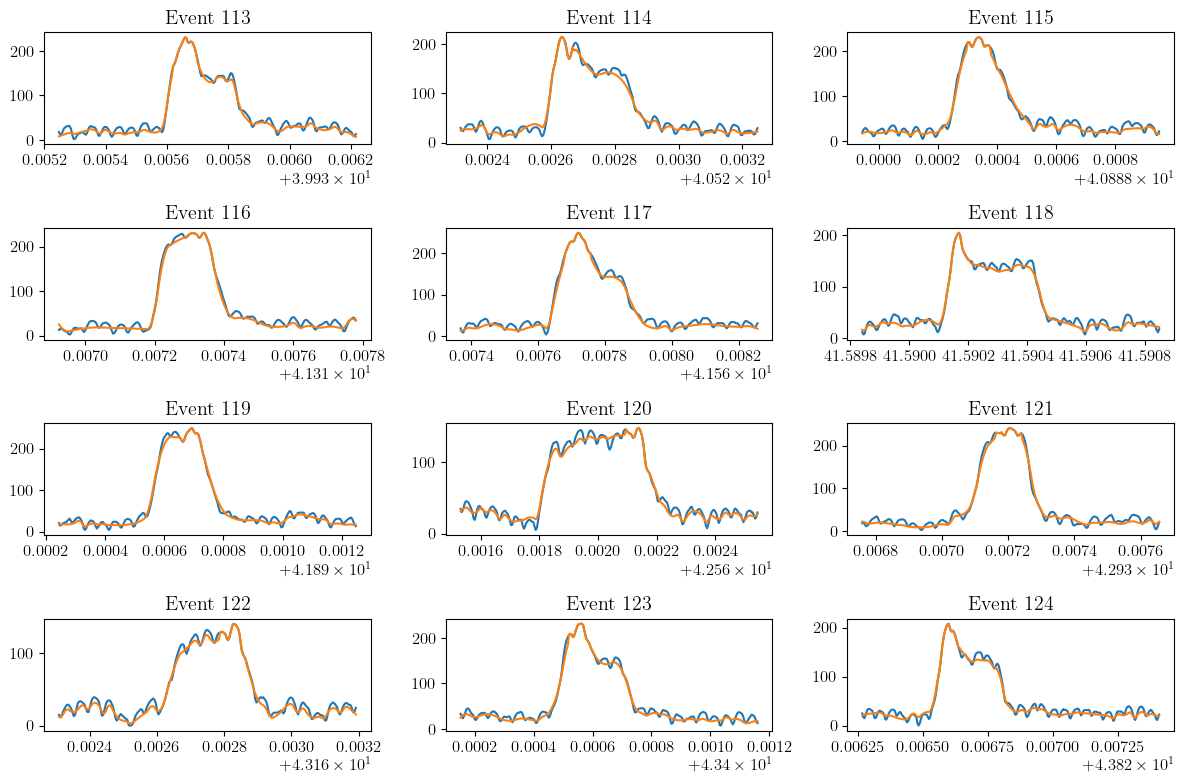

In [102]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))
axs = axs.flatten()

for i, ax in zip(range(112, 124), axs):

    ax.plot(time_list[i], counts_list[i])
    ax.plot(time_list[i], DWT_rec_test[i])
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (uA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    #ax.set_ylim(-30, 60)

plt.tight_layout()
plt.show()

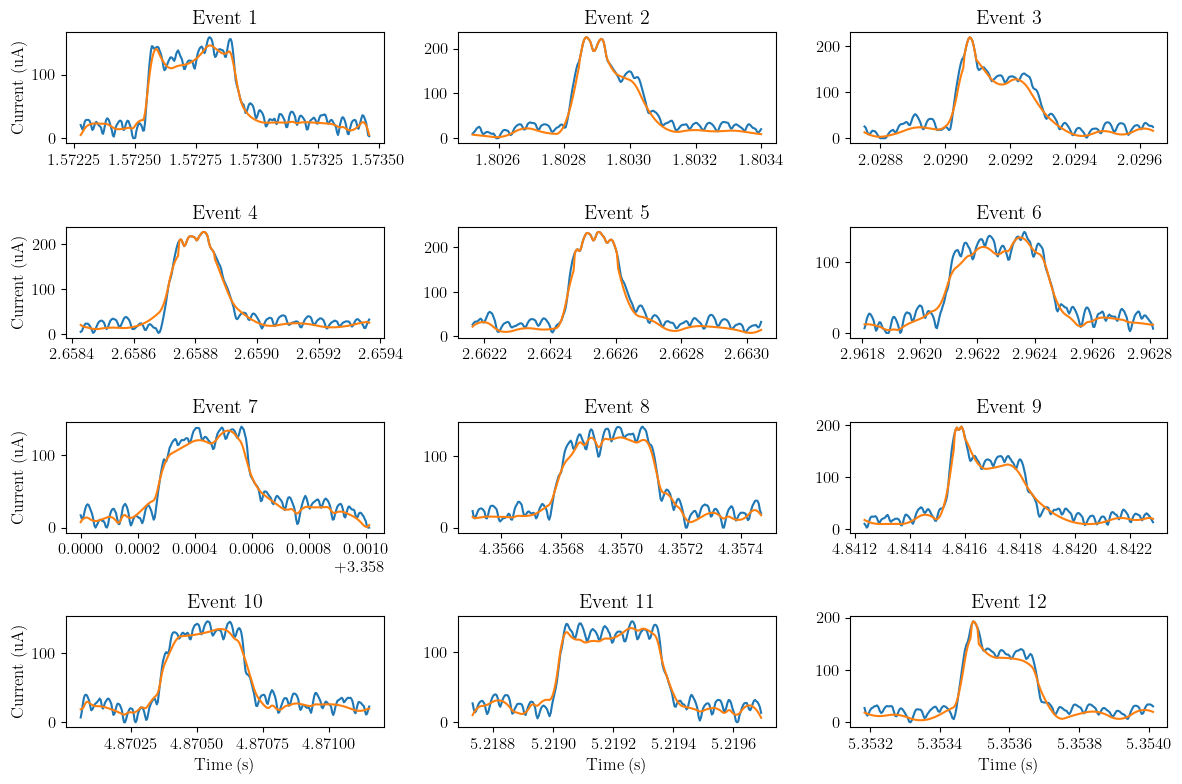

In [315]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))
axs = axs.flatten()

for i, ax in zip(range(12), axs):

    ax.plot(time_list[i], counts_list[i])
    ax.plot(time_list[i], DWT_rec_test[i])
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (uA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    #ax.set_ylim(-30, 60)

plt.tight_layout()
plt.show()

In [73]:
len(DWT_rec_padded_test[0])

600

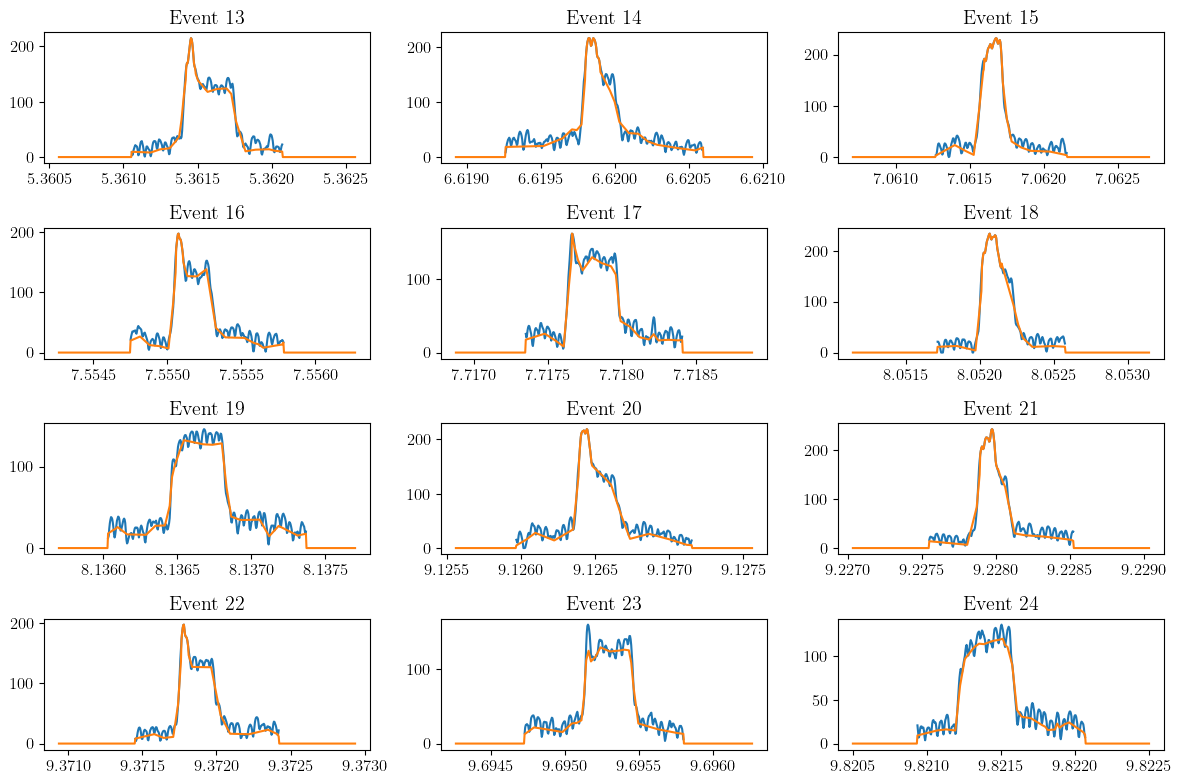

In [442]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))
axs = axs.flatten()

for i, ax in zip(range(12,24), axs):

    ax.plot(time_list[i], counts_list[i])
    ax.plot(event_time_padded_bior22[i], DWT_rec_padded_bior22[i])
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (pA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    #ax.set_ylim(-30, 60)

plt.tight_layout()
plt.show()

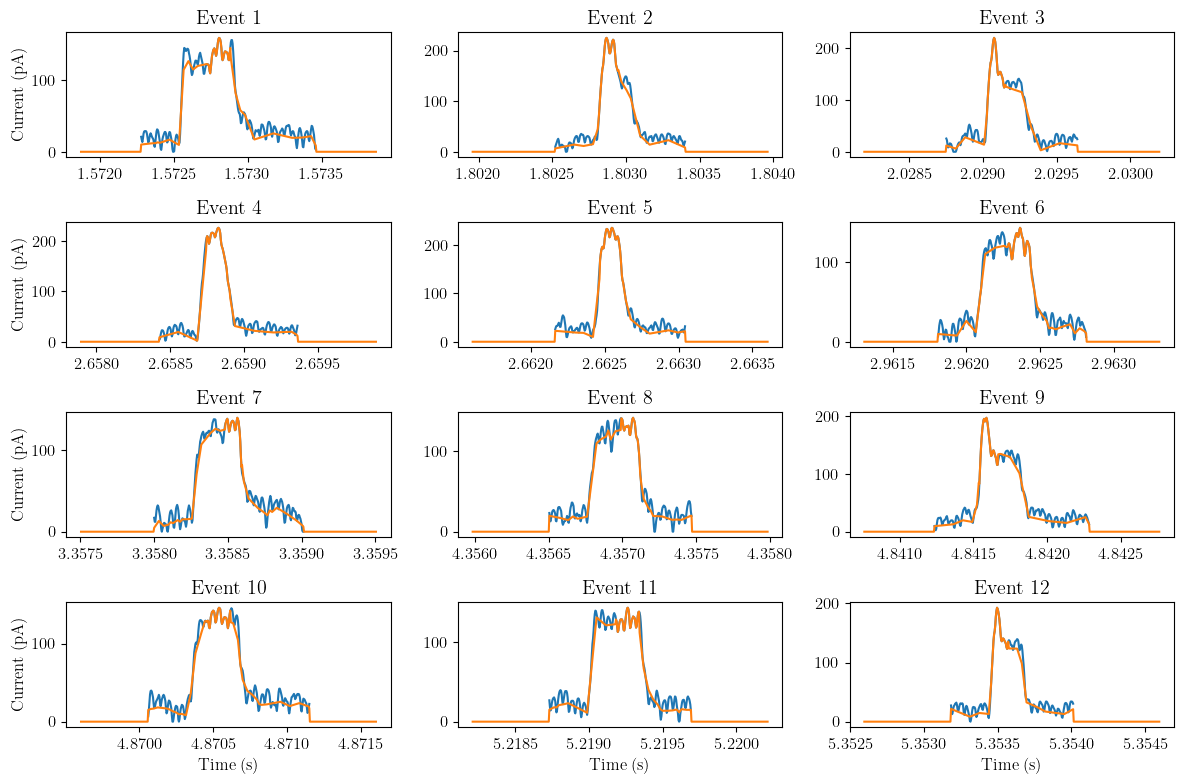

In [345]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))
axs = axs.flatten()

for i, ax in zip(range(12), axs):

    ax.plot(time_list[i], counts_list[i])
    ax.plot(df_events_all_wavelets_02_DNA["bior2.2"][0][i], df_events_all_wavelets_02_DNA["bior2.2"][1][i])
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (pA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    #ax.set_ylim(-30, 60)

plt.tight_layout()
plt.show()

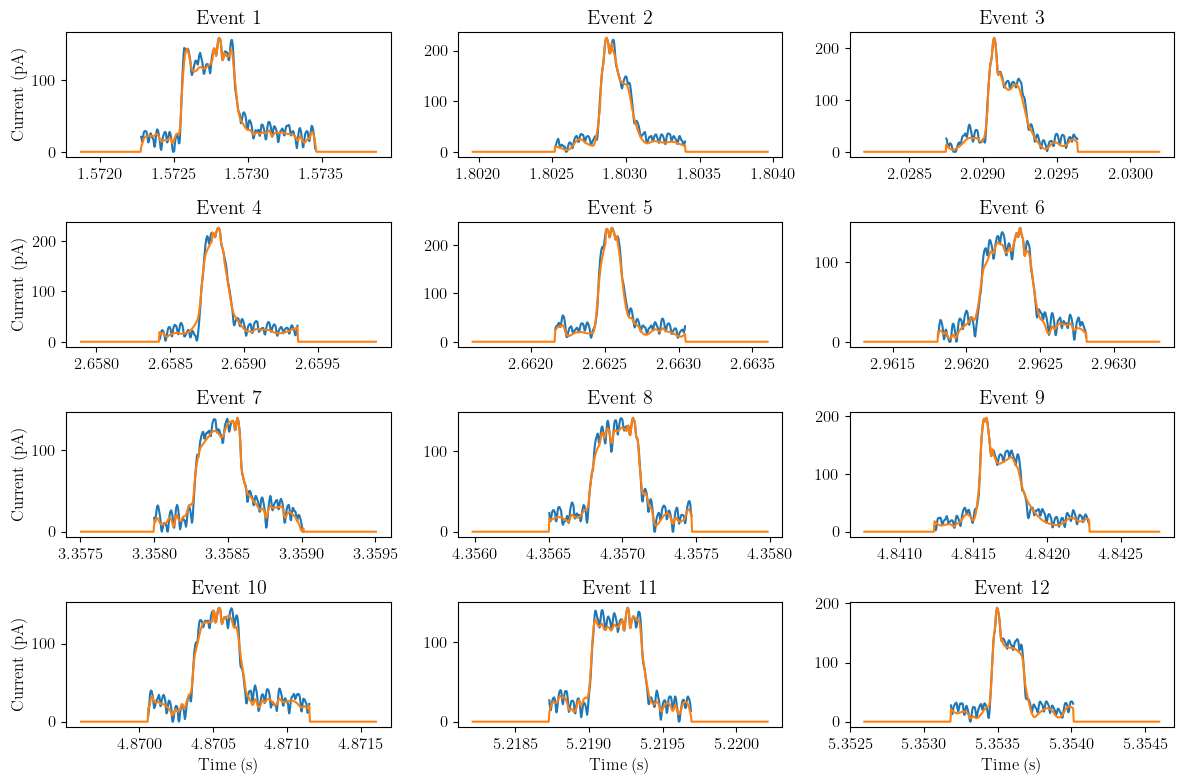

In [312]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))
axs = axs.flatten()

for i, ax in zip(range(12), axs):

    ax.plot(time_list[i], counts_list[i])
    ax.plot(df_events_all_wavelets_015_DNA["bior3.3"][0][i], df_events_all_wavelets_015_DNA["bior3.3"][1][i])
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (pA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    #ax.set_ylim(-30, 60)

plt.tight_layout()
plt.show()

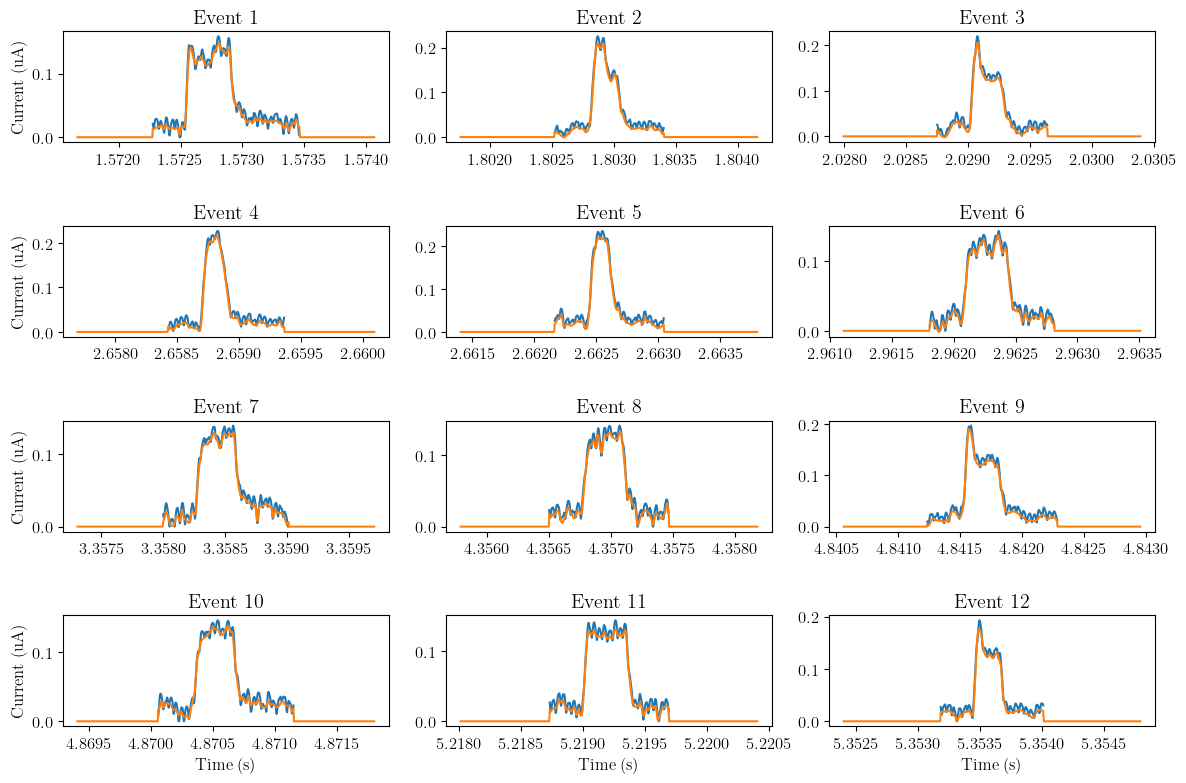

In [40]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))
axs = axs.flatten()

for i, ax in zip(range(12), axs):

    ax.plot(time_list[i], counts_list[i])
    ax.plot(event_time_padded_test[i], DWT_rec_padded_test[i])
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (nA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    #ax.set_ylim(-30, 60)

plt.tight_layout()
plt.show()

##### Time Series KMeans

In [31]:
df_events_all_wavelets_005_DNA = unpickle("df_events_all_wavelets_005_DNA.pkl")
df_all_wavelets_005_DNA = unpickle("df_all_wavelets_005_DNA.pkl")
df_events_all_wavelets_015_DNA = unpickle("df_events_all_wavelets_015_DNA.pkl")
df_all_wavelets_015_DNA = unpickle("df_all_wavelets_015_DNA.pkl")
df_events_all_wavelets_02_DNA = unpickle("df_events_all_wavelets_02_DNA.pkl")


In [3]:
df_all_wavelets_02_DNA = unpickle("df_all_wavelets_02_DNA.pkl")


In [11]:
print("f")

In [13]:
def find_FWHM_idx_DNA(event):
    # sometimes we encounter many points at the half maximum
    # event_smooth is a single event
    start, end = 0, 0
    
    half_max_peak = np.max(event)/2
    intercepts = np.where(np.diff(np.sign(event - half_max_peak)))[0] # find where the signal crosses the half max value
    
    start = intercepts[intercepts < np.argmax(event)]
    start = start[-1] if start.size != 0 else 0
    end = intercepts[intercepts > np.argmax(event)]
    end = end[0] if end.size != 0 else len(event) - 1

        
    return start, end

In [240]:
find_FWHM_idx_DNA(df_events_all_wavelets_015_DNA["bior3.3"][1][10])

(200, 290)

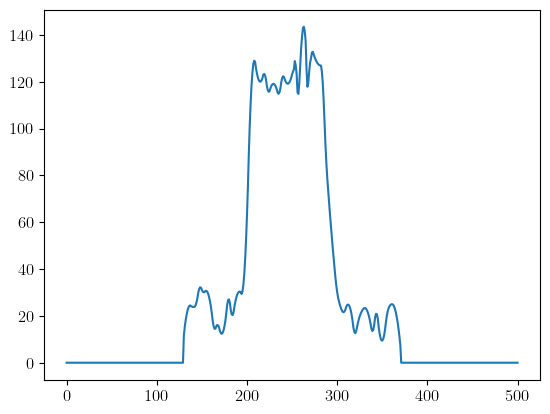

In [238]:
plt.plot(df_events_all_wavelets_015_DNA["bior3.3"][1][10])

In [11]:
def centre_peak_DNA(time, data, peak_loc):
    """ lines up events in the midddle

    Args:
        time, data: list of arrays

    Returns:
        centered_time, centered_data
    """
    centered_data = []
    centered_time = []
    for i in range(len(data)):
        start, end = find_FWHM_idx_DNA(data[i])
        middle = int((start + end) / 2)
        peak = np.argmax(data[i])
        shift = peak_loc - middle
        centered_data.append(np.roll(data[i], shift))
        centered_time.append(np.roll(time[i], shift))
    
    return centered_time, centered_data

In [110]:
events_centred_time, events_centred_data = centre_peak_DNA(df_events_all_wavelets_015_DNA["bior3.3"][0], df_events_all_wavelets_015_DNA["bior3.3"][1], 250)

In [14]:
events_centred_time, events_centred_data = centre_peak_DNA(df_events_all_wavelets_02_DNA["bior3.3"][0], df_events_all_wavelets_02_DNA["bior3.3"][1], 250)

In [15]:
scaler = TimeSeriesScalerMeanVariance()
#scaled_time_series_data_NR = scaler.fit_transform(np.array(df_events_all_wavelets_015_DNA["bior3.3"][1]))
scaled_time_series_data_NR = scaler.fit_transform(events_centred_data)
flattened_data = np.array(events_centred_data)



# if scaled_time_series_data_NR.shape[2] == 1:
#     flattened_data = scaled_time_series_data_NR.reshape(scaled_time_series_data_NR.shape[0], -1)
# else:
#     raise ValueError("Silhouette score computation requires 2D data.")


In [652]:
num_clusters_range = range(1, 21)  

models_dic = {}
labels_dic = {}

results_KMeans_df = pd.DataFrame(columns=["Num_Clusters", "Inertia", "Silhouette_Score"])

for k in num_clusters_range:
    model = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=10, n_jobs=-1, init='k-means++', random_state=42).fit(flattened_data) #init='k-means++')
    labels = model.labels_

    models_dic[f"n={k}"] = model
    labels_dic[f"n={k}"] = labels

    inertia = model.inertia_
    if k == 1:
        silhouette_score_value = None
    else:
        silhouette_score_value = silhouette_score(flattened_data, labels)

    results_KMeans_df.loc[k-1] = [int(k), inertia, silhouette_score_value]


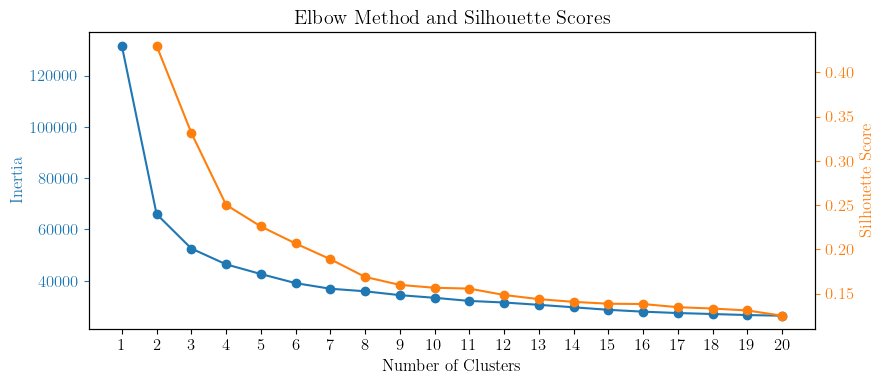

In [653]:
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plotting Inertia on the left y-axis
ax1.plot(results_KMeans_df["Num_Clusters"], results_KMeans_df["Inertia"], color='#1f77b4', marker='o')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='#1f77b4')
ax1.tick_params('y', colors='#1f77b4')
ax1.set_xticks(num_clusters_range)

# Create another y-axis for the Silhouette Score
ax2 = ax1.twinx()
ax2.plot(results_KMeans_df["Num_Clusters"], results_KMeans_df["Silhouette_Score"], color='#ff7f0e', marker='o')
ax2.set_ylabel('Silhouette Score', color='#ff7f0e')
ax2.tick_params('y', colors="#ff7f0e")

# Setting titles and layout
plt.title('Elbow Method and Silhouette Scores')
plt.tight_layout()
#plt.savefig("MSci_python_images/.png", dpi=300)
plt.show()


In [700]:
print(model_bior22.cluster_centers_.shape)


(1, 501, 1)


In [152]:
events_centred_time_bior22, events_centred_data_bior22 = centre_peak_DNA(event_time_padded_bior22, DWT_rec_padded_bior22, 250)
scaler_bior22 = TimeSeriesScalerMeanVariance()
scaled_time_series_data_NR_bior22 = scaler_bior22.fit_transform(events_centred_data_bior22)

num_clusters_range = range(1, 21)  


if scaled_time_series_data_NR.shape[2] == 1:
    flattened_data_bior22 = scaled_time_series_data_NR_bior22.reshape(scaled_time_series_data_NR_bior22.shape[0], -1)
else:
    raise ValueError("Silhouette score computation requires 2D data.")

models_dic_bior22 = {}
labels_dic_bior22 = {}

n = flattened_data_bior22.shape[0]  
d = flattened_data_bior22.shape[1]  
bic_values = []

results_KMeans_df_bior22 = pd.DataFrame(columns=["Num_Clusters", "Inertia", "Silhouette_Score"])

for k in num_clusters_range:
    model_bior22 = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=10, n_jobs=-1, init='k-means++', random_state=42).fit(flattened_data_bior22) #init='k-means++')
    labels_bior22 = model_bior22.labels_

    models_dic_bior22[f"n={k}"] = model_bior22
    labels_dic_bior22[f"n={k}"] = labels_bior22
    
    cluster_centers_reshaped = model_bior22.cluster_centers_.reshape(-1, d)  # d is your number of features
    wcss = sum(np.min(cdist(flattened_data_bior22, cluster_centers_reshaped, 'euclidean'), axis=1)) / n

    log_likelihood = -d * 0.5 * np.log(wcss) * n
    p = k * d + 1
    bic = np.log(n) * p - 2 * log_likelihood
    bic_values.append(bic)

    inertia_test = model_bior22.inertia_
    if k == 1:
        silhouette_score_value_bior22 = None
    else:
        silhouette_score_value_bior22 = silhouette_score(flattened_data_bior22, labels_bior22)

    results_KMeans_df_bior22.loc[k-1] = [int(k), inertia_test, silhouette_score_value_bior22]


In [37]:
from scipy.spatial.distance import cdist

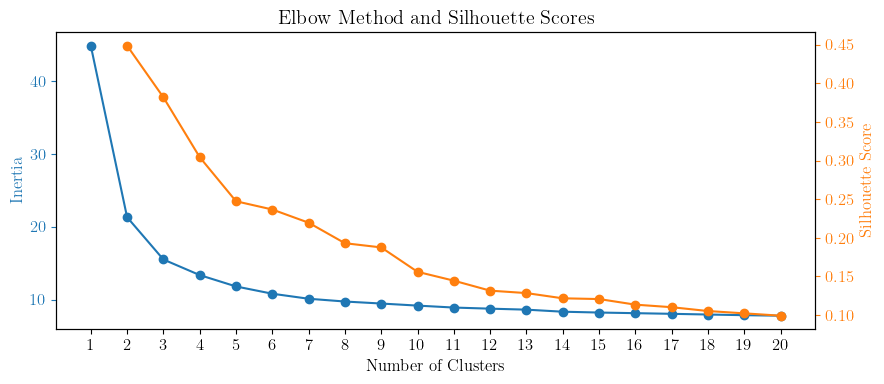

In [355]:
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plotting Inertia on the left y-axis
ax1.plot(results_KMeans_df_bior22["Num_Clusters"], results_KMeans_df_bior22["Inertia"], color='#1f77b4', marker='o')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='#1f77b4')
ax1.tick_params('y', colors='#1f77b4')
ax1.set_xticks(num_clusters_range)

# Create another y-axis for the Silhouette Score

ax2 = ax1.twinx()
ax2.plot(results_KMeans_df_bior22["Num_Clusters"], results_KMeans_df_bior22["Silhouette_Score"], color='#ff7f0e', marker='o')
ax2.set_ylabel('Silhouette Score', color='#ff7f0e')
ax2.tick_params('y', colors="#ff7f0e")

# Setting titles and layout
plt.title('Elbow Method and Silhouette Scores')
plt.tight_layout()
#plt.savefig("MSci_python_images/.png", dpi=300)
plt.show()

In [25]:
def plot_timeseriesKMeans(num_clusters, flattened_data, model = None, labels = None, file_name = None, ylim = None):
    if model is None or labels is None:
        model = models_dic[f"n={num_clusters}"]
        labels = labels_dic[f"n={num_clusters}"]

    alphabet = ["A", "B", "C", "D", "E"]
    # Set up the subplot grid: one row for each cluster and one for the centroids
    fig, axs = plt.subplots(num_clusters + 1, 1, figsize=(10, 3 * (num_clusters + 1)))#, dpi = 300)

    for cluster_idx in range(num_clusters):
        #colours = ["tab:purple", "tab:gray", "tab:olive"]
        #colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
        # Plot each time series in the cluster
        for series in flattened_data[labels == cluster_idx]:
            axs[cluster_idx].plot(series.ravel(), alpha=0.1)#, color=colours[cluster_idx])

        # Plot the centroid
        axs[cluster_idx].plot(model.cluster_centers_[cluster_idx].ravel(), color='red', linewidth=2, label = f'Centroid {alphabet[cluster_idx]}')
        axs[cluster_idx].set_xlabel("Data Index")
        axs[cluster_idx].set_ylabel("Scaled Current")
        axs[cluster_idx].legend()
        if ylim:
            axs[cluster_idx].set_ylim(ylim[0], ylim[1])
        axs[cluster_idx].set_xlim(0, len(series.ravel()))

    # Plot all centroids in the last subplot
    axs[num_clusters].set_title("All Cluster Centroids")
    for cluster_idx in range(num_clusters):
        
        axs[num_clusters].plot(np.linspace(0, 501* 4e-6, 501), model.cluster_centers_[cluster_idx].ravel(), label=f'Centroid {alphabet[cluster_idx]}')

    axs[num_clusters].set_xlabel("Time (s)")
    axs[num_clusters].set_ylabel("Scaled Current")
    axs[num_clusters].legend()
    

    plt.tight_layout()
    if file_name:
        plt.savefig("MSci_python_images/" + file_name + ".png", dpi = 300)
    plt.show()

In [156]:
plot_timeseriesKMeans(3, flattened_data)

NameError: name 'models_dic' is not defined

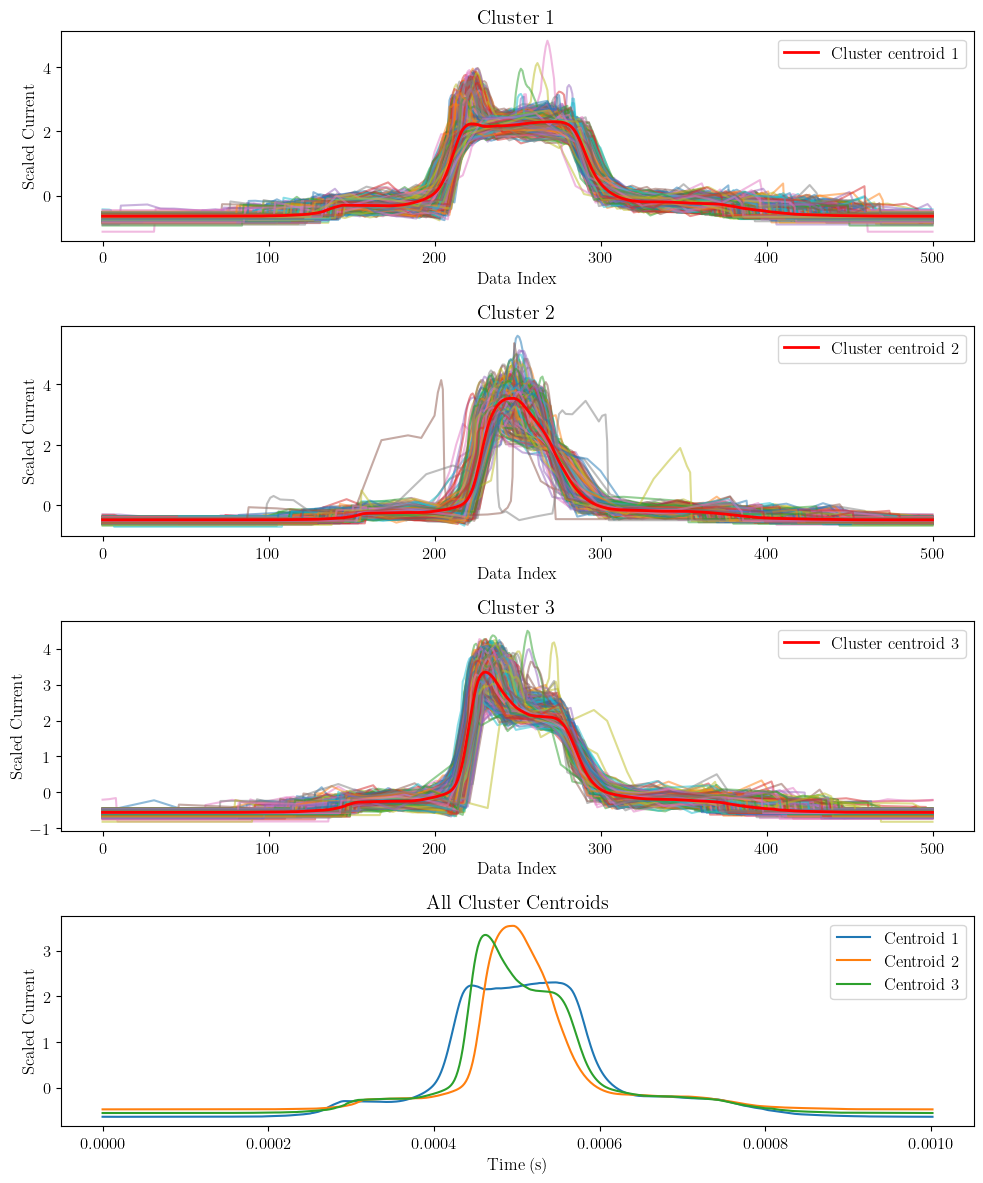

In [356]:
plot_timeseriesKMeans(3, flattened_data_bior22)

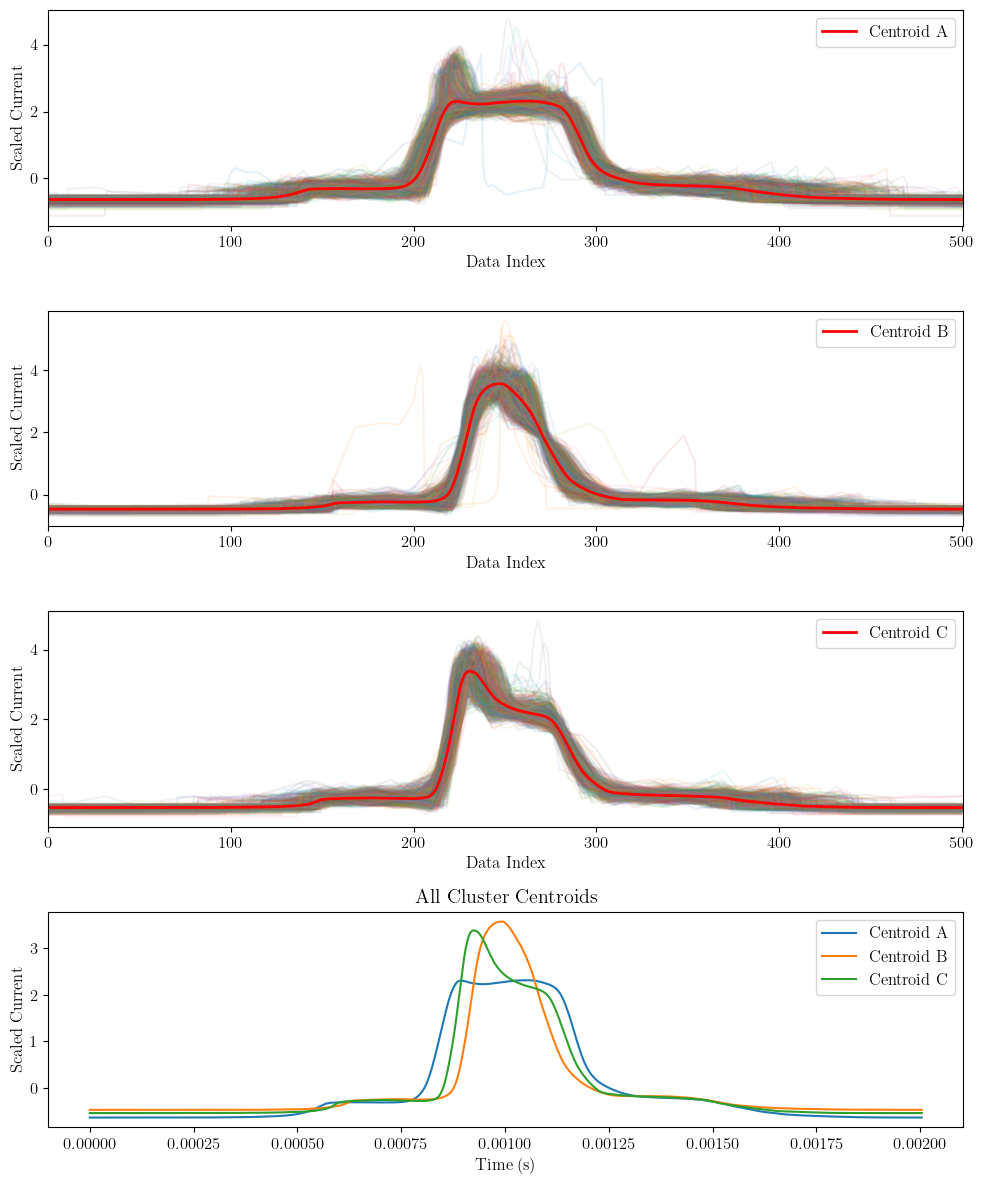

In [160]:
plot_timeseriesKMeans(3, flattened_data=flattened_data_bior22, model = models_dic_bior22["n=3"], labels = labels_dic_bior22["n=3"])

In [161]:
for i in models_dic_bior22["n=3"].cluster_centers_:
    print(skew(i))

[1.6227]
[2.6334]
[2.1334]


In [740]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_timeseriesKMeans_blur(num_clusters, flat_data, model=None, labels=None, file_name=None, ylim=None):
    if model is None or labels is None:
        model = models_dic[f"n={num_clusters}"]
        labels = labels_dic[f"n={num_clusters}"]

    fig, axs = plt.subplots(num_clusters + 1, 1, figsize=(10, 3 * (num_clusters + 1)))

    for cluster_idx in range(num_clusters):
        axs[cluster_idx].set_title(f"Cluster {cluster_idx + 1}")
        cluster_data = flat_data[labels == cluster_idx]

        # Calculate the mean and standard deviation for the time series in this cluster
        mean_series = np.mean(cluster_data, axis=0)
        std_deviation = np.std(cluster_data, axis=0)

        # Plot the mean time series
        axs[cluster_idx].plot(model.cluster_centers_[cluster_idx].ravel(), color='red', linewidth=2, label=f"Cluster centroid {cluster_idx + 1}")

        # Add a shaded area around the mean
        axs[cluster_idx].fill_between(range(len(mean_series)), mean_series - std_deviation, mean_series + std_deviation, color='red', alpha=0.2)

        axs[cluster_idx].set_xlabel("Data Index")
        axs[cluster_idx].set_ylabel("Scaled Current")
        axs[cluster_idx].legend(loc='upper right')
        if ylim:
            axs[cluster_idx].set_ylim(ylim[0], ylim[1])

    # Plot all centroids in the last subplot
    axs[num_clusters].set_title("All Cluster Centroids")
    for cluster_idx in range(num_clusters):
        axs[num_clusters].plot(model.cluster_centers_[cluster_idx].ravel(), label=f'Centroid {cluster_idx + 1}')

    axs[num_clusters].set_xlabel("Time (s)")
    axs[num_clusters].set_ylabel("Scaled Current")
    axs[num_clusters].legend(loc='upper right')

    plt.tight_layout()
    if file_name:
        plt.savefig(file_name + ".png", dpi=300)
    plt.show()

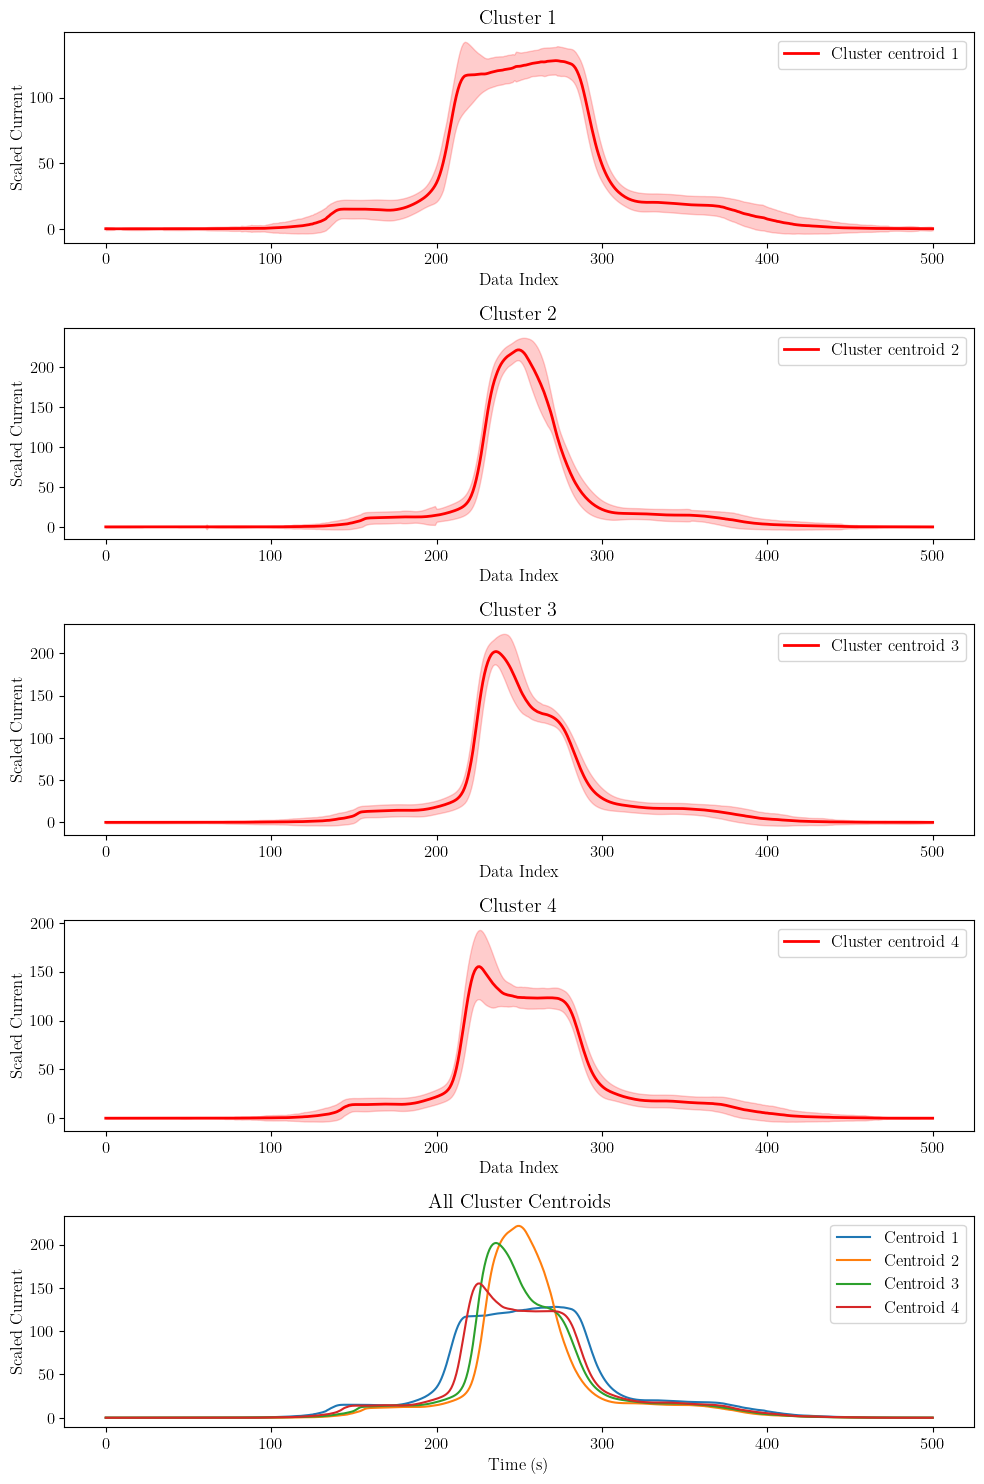

In [741]:
plot_timeseriesKMeans_blur(4, flattened_data)

In [251]:
def centroid_subplots(num_clusters, flattened_data, model = None, labels = None, file_name = None, ylim = None):
    if model is None or labels is None:
        model = models_dic[f"n={num_clusters}"]
        labels = labels_dic[f"n={num_clusters}"]
    
    # Calculate rows based on the number of clusters, ensuring there are two columns
    rows = int(np.ceil(num_clusters / 2))
    
    fig, axs = plt.subplots(rows, 2, figsize=(10, 3 * num_clusters/2))  # Adjust figsize as needed
    
    # Flatten the axs array for easy indexing if it's 2D
    axs = axs.flatten()
    
    for cluster_idx in range(num_clusters):
        # Indexing axs with cluster_idx directly thanks to flattening
        axs[cluster_idx].plot(np.linspace(0, 501 * 2e-6, 501), model.cluster_centers_[cluster_idx].ravel(), label=f'Centroid {cluster_idx + 1}')
        axs[cluster_idx].set_xlabel("Time (s)")
        axs[cluster_idx].set_ylabel("Scaled Current")
        axs[cluster_idx].legend()
        if ylim:
            axs[cluster_idx].set_ylim(ylim[0], ylim[1])
        else:
            axs[cluster_idx].set_ylim(-1, 5)
        print(f"{cluster_idx} max = {np.max(model.cluster_centers_[cluster_idx].ravel())}")
        
    # If the number of clusters is odd, we'll have an extra subplot. Here's how to hide it.
    if num_clusters % 2 != 0:
        axs[-1].axis('off')  # Hide the last subplot if unused
        
    plt.tight_layout()
    if file_name:
        plt.savefig("MSci_python_images/" + file_name + ".png", dpi = 300)
    plt.show()


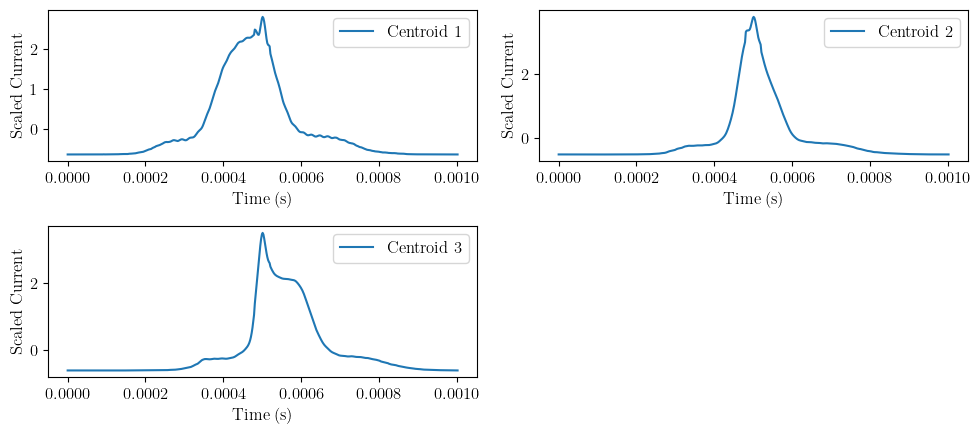

In [160]:
centroid_subplots(3, flattened_data)

In [192]:
anomaly_indices = [i for i, arr in enumerate(flattened_data) if labels[i] == 0 and np.max(arr) > 2.9]
len(anomaly_indices)

28

In [ ]:
len(anomaly_indices)

In [193]:
cleaned_data = [arr for i, arr in enumerate(flattened_data) if i not in anomaly_indices]
cleaned_labels = np.delete(labels, anomaly_indices)

In [194]:
num_clusters = 3  # Example, adjust based on your specific case

# Convert cleaned_data back to a suitable format for TimeSeriesKMeans if necessary
cleaned_data_array = np.array(cleaned_data)  # Ensure data is in the correct format

# Initialize and fit the model with cleaned data
model = TimeSeriesKMeans(n_clusters=num_clusters, metric="euclidean", max_iter=10, n_jobs=-1, init='k-means++', random_state=42).fit(cleaned_data_array) #init='k-means++')

# Extract new labels if needed
new_labels = model.labels_

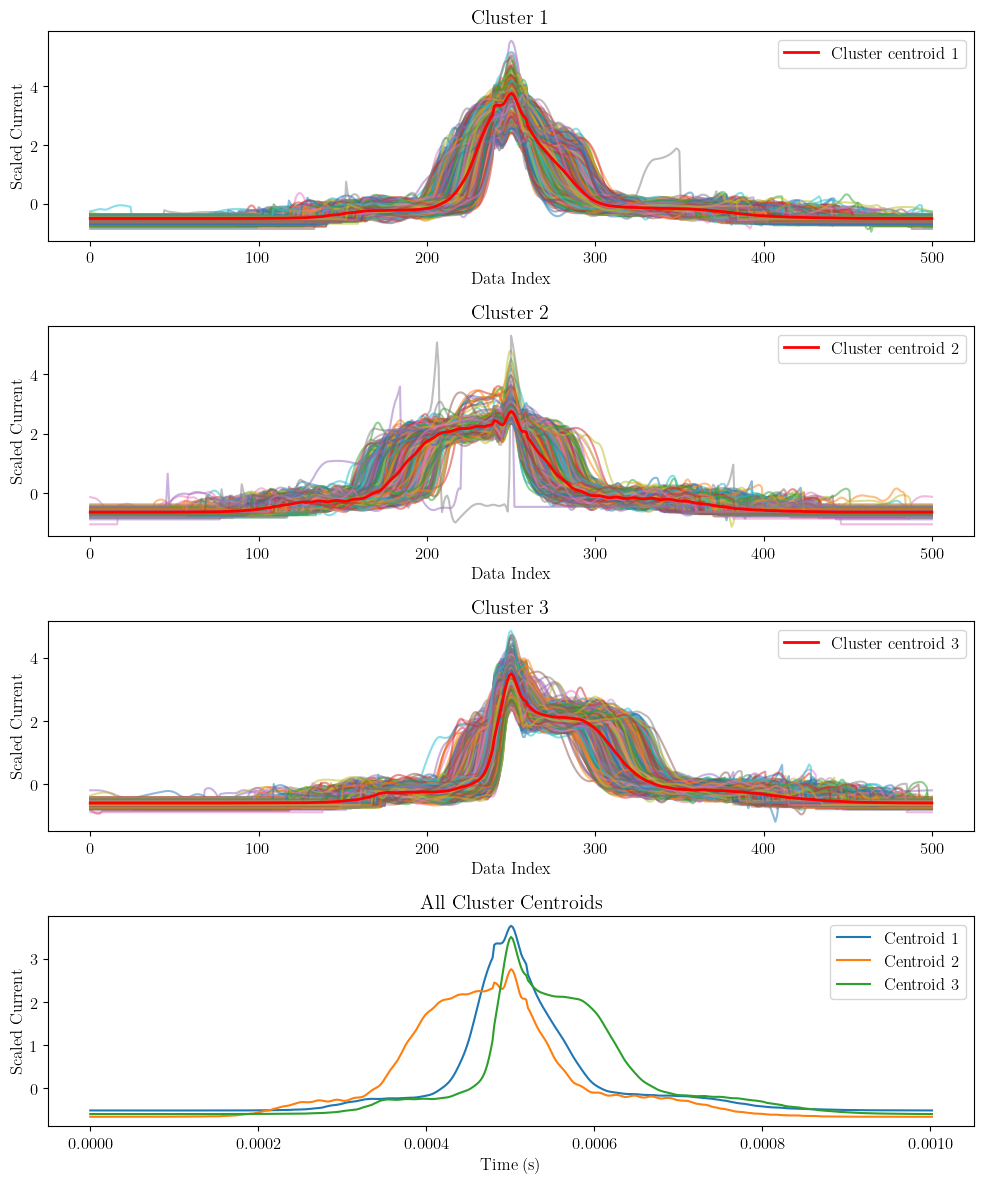

In [195]:
plot_timeseriesKMeans(3, cleaned_data_array, model, new_labels)

DTW

In [ ]:
len(flattened_data)

3164

In [357]:

model_DTW_bior22 = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++').fit(flattened_data_bior22) #init='k-means++')
labels_DTW_bior22 = model_DTW_bior22.labels_


inertia_DTW_bior22 = model_DTW_bior22.inertia_
silhouette_score_value_DTW_bior22 = silhouette_score(flattened_data_bior22, labels_DTW_bior22)


In [157]:
plot_timeseriesKMeans(3, flattened_data_bior22, model = model_DTW_bior22, labels = labels_DTW_bior22, file_name = "KMeans_DTW_02_bior22", ylim = (-1, 6))

NameError: name 'model_DTW_bior22' is not defined

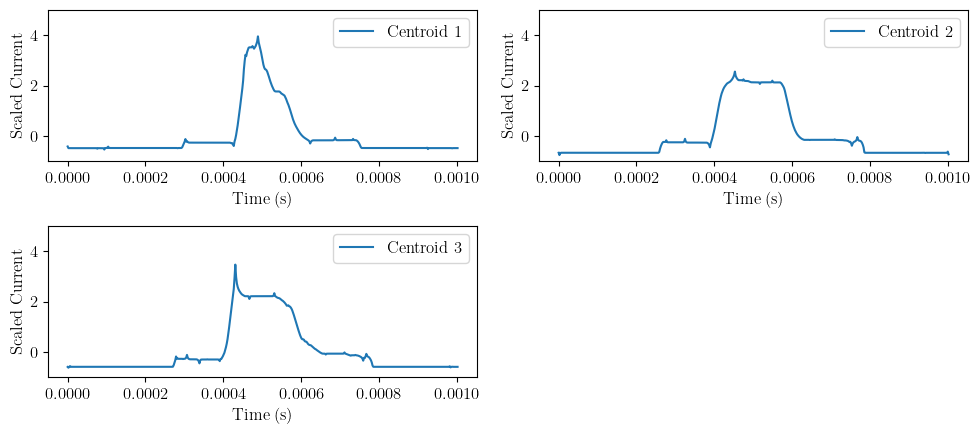

In [362]:
centroid_subplots(3, flattened_data_bior22, model = model_DTW_bior22, labels = labels_DTW_bior22)

In [21]:
events_centred_time_bior22, events_centred_data_bior22 = centre_peak_DNA(event_time_padded_bior22, DWT_rec_padded_bior22, 250)


In [22]:
flattened_data_bior22_unscaled = np.array(events_centred_data_bior22)

In [24]:
save_with_pickle("flattened_data_bior22_unscaled.pkl", flattened_data_bior22_unscaled)


In [2]:
flattened_data_bior22_unscaled = unpickle("flattened_data_bior22_unscaled.pkl")

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

model_DTW = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=6, n_jobs=-1, init='k-means++', random_state=42).fit(event_data)
labels_DTW = model_DTW.labels_

inertia_DTW= model_DTW.inertia_
silhouette_score = silhouette_score(flattened_data_bior22_unscaled, labels_DTW)


In [3]:

model_DTW_bior22_unscaled = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++', random_state=42).fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled = model_DTW_bior22_unscaled.labels_


inertia_DTW_bior22_unscaled = model_DTW_bior22_unscaled.inertia_
silhouette_score_value_DTW_bior22_unscaled = silhouette_score(flattened_data_bior22_unscaled, labels_DTW_bior22_unscaled)


In [6]:

model_DTW_bior22_unscaled2 = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++', random_state=41).fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled2 = model_DTW_bior22_unscaled2.labels_



In [7]:

model_DTW_bior22_unscaled3 = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++', random_state=43).fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled3 = model_DTW_bior22_unscaled3.labels_



In [18]:
save_with_pickle("DNA_model_DTW_bior22_unscaled3", model_DTW_bior22_unscaled3)
save_with_pickle("DNA_labels_DTW_bior22_unscaled3", labels_DTW_bior22_unscaled3)


In [8]:

model_DTW_bior22_unscaled4 = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++', random_state=45).fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled4 = model_DTW_bior22_unscaled4.labels_


inertia_DTW_bior22_unscaled = model_DTW_bior22_unscaled.inertia_
silhouette_score_value_DTW_bior22_unscaled = silhouette_score(flattened_data_bior22_unscaled, labels_DTW_bior22_unscaled)

In [9]:

model_DTW_bior22_unscaled5 = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++', random_state=320).fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled5 = model_DTW_bior22_unscaled5.labels_


inertia_DTW_bior22_unscaled = model_DTW_bior22_unscaled.inertia_
silhouette_score_value_DTW_bior22_unscaled = silhouette_score(flattened_data_bior22_unscaled, labels_DTW_bior22_unscaled)

In [10]:

model_DTW_bior22_unscaled6 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++', random_state=452).fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled6 = model_DTW_bior22_unscaled6.labels_



In [11]:

model_DTW_bior22_unscaled7 = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++', random_state=452).fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled7 = model_DTW_bior22_unscaled7.labels_

In [12]:

model_DTW_bior22_unscaled8 = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=2, n_jobs=-1, init='k-means++', random_state=452).fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled8 = model_DTW_bior22_unscaled8.labels_

In [166]:
for i in model_DTW_bior22_unscaled.cluster_centers_:
    print(skew(i))

[1.6295]
[2.7381]
[2.4338]


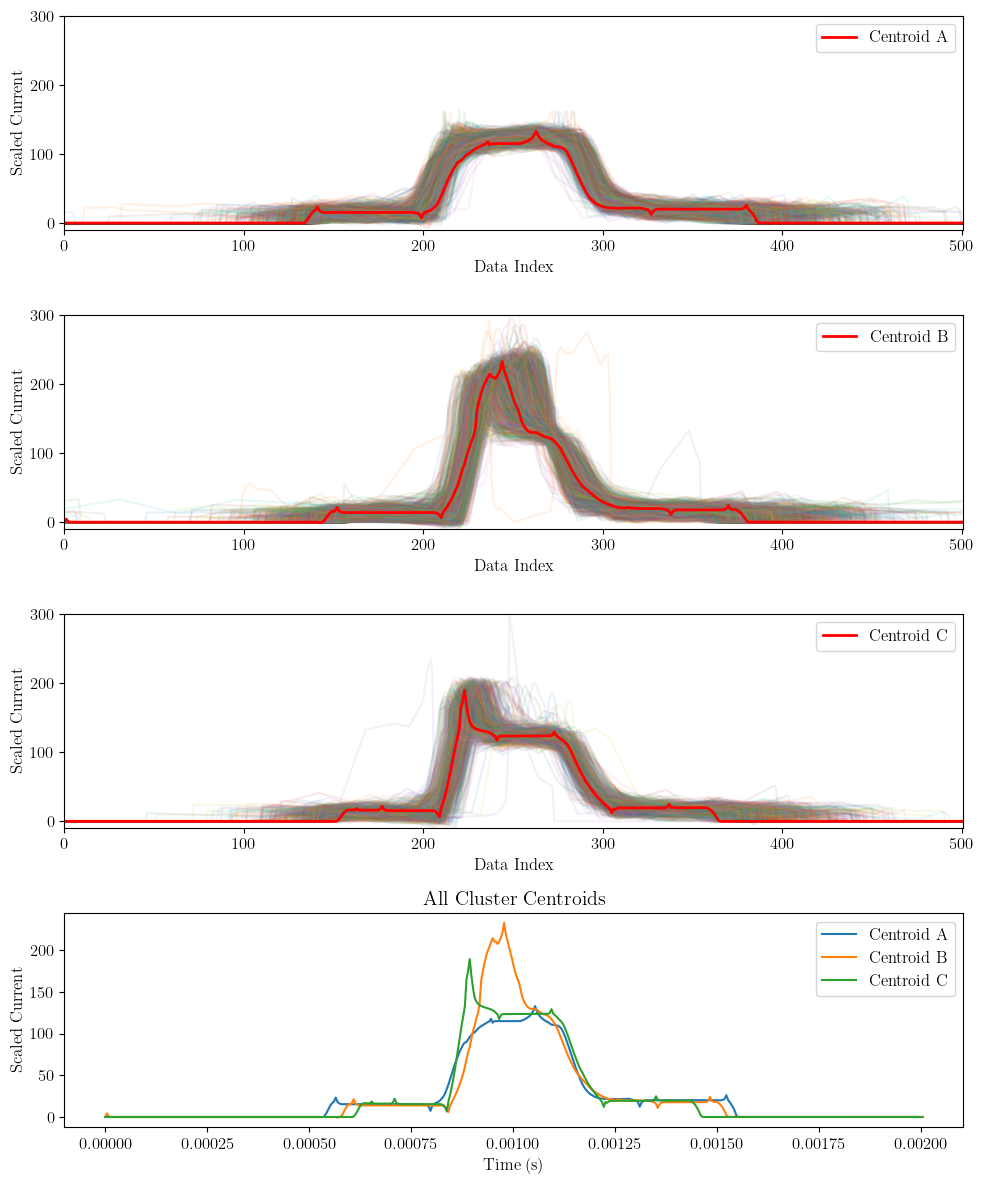

In [16]:
plot_timeseriesKMeans(3, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled3, labels = labels_DTW_bior22_unscaled3, ylim = (-10, 300))

IndexError: list index out of range

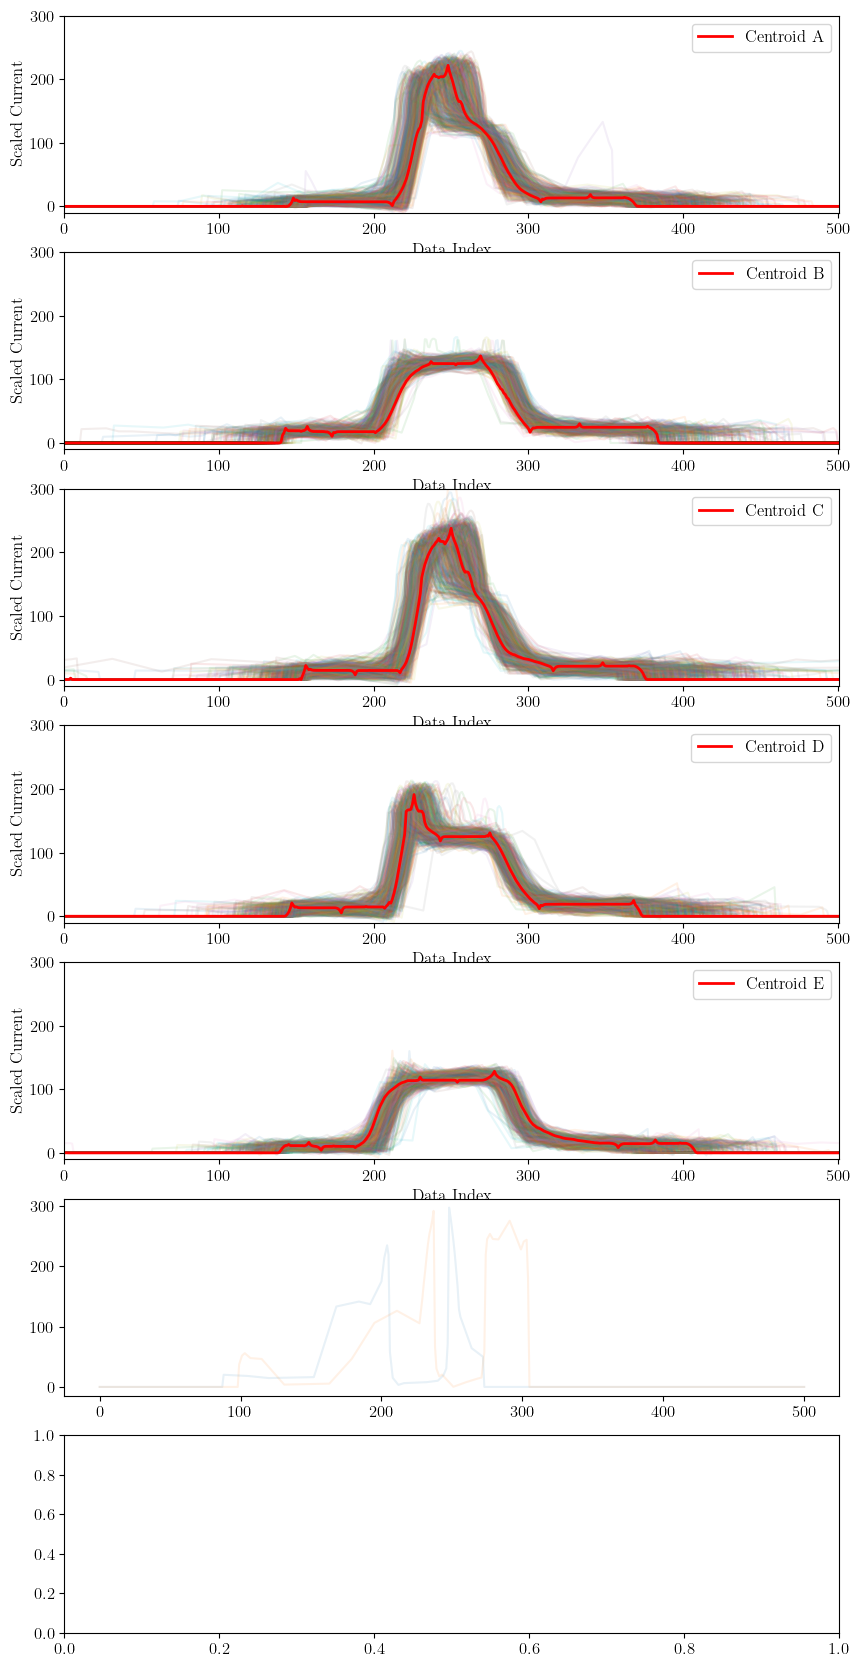

In [28]:
plot_timeseriesKMeans(6, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled8, labels = labels_DTW_bior22_unscaled8, ylim = (-10, 300))

0 max = 199.08642076502764
1 max = 134.60589156131573
2 max = 235.29072694972123


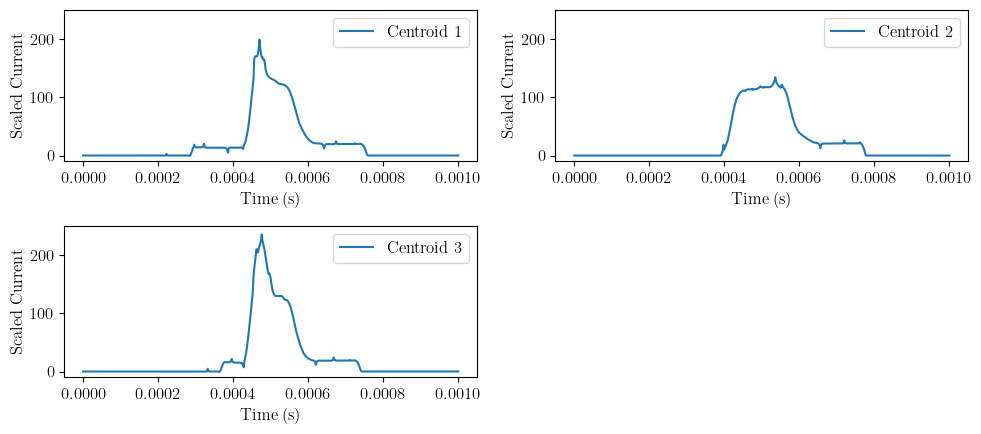

In [264]:
centroid_subplots(3, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled, labels = labels_DTW_bior22_unscaled, ylim = [-10, 250])

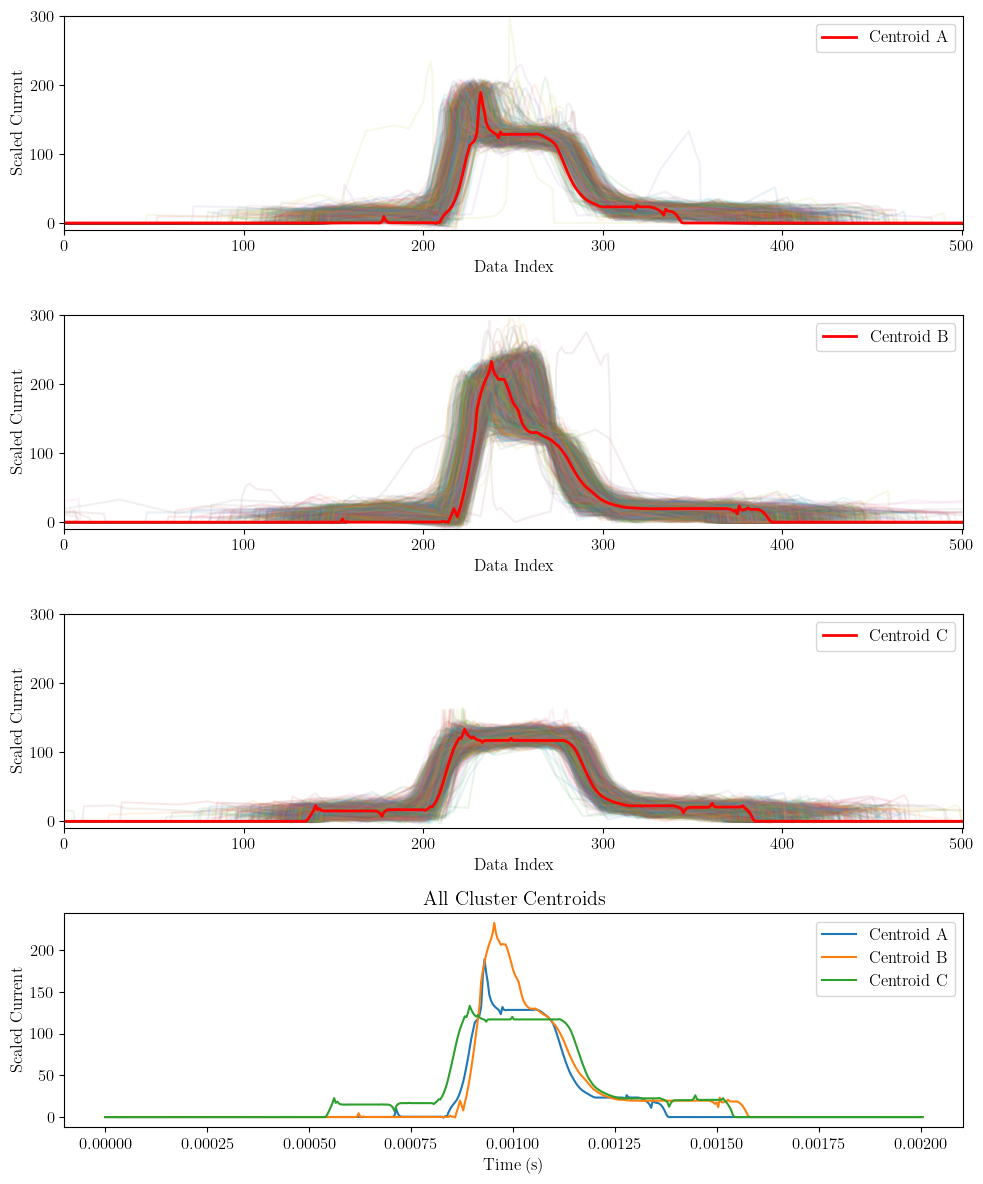

In [756]:
plot_timeseriesKMeans(3, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled, labels = labels_DTW_bior22_unscaled, file_name = "KMeans_DTW_02_bior22_unscaled", ylim = (-10, 300))

In [259]:
for cluster in model_DTW_bior22_unscaled.cluster_centers_:
    print(find_dwell_time_FWHM(np.linspace(0, 501 * 4e-6, 501), cluster.ravel(), "peak-only"))

0.0002164319999999999
0.00032063999999999997
0.00020039999999999988


In [263]:
%matplotlib inline

0 max = 188.97073912025692
1 max = 232.5461324529448
2 max = 133.26876879930924


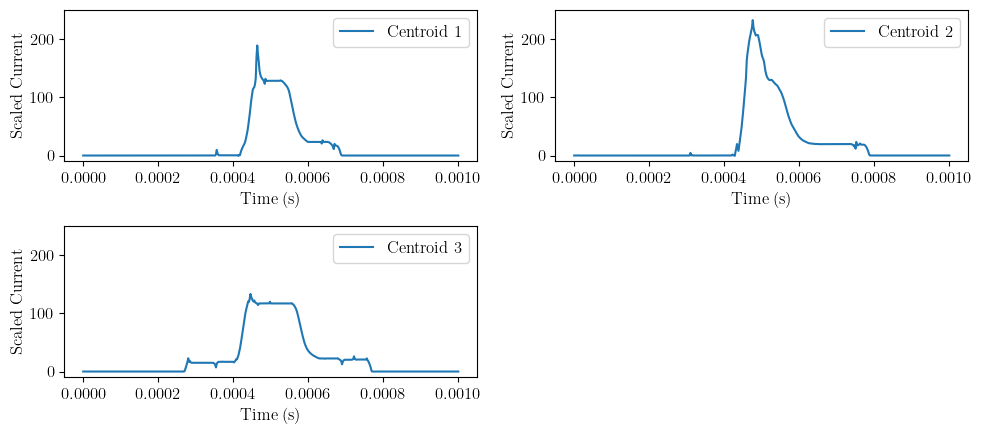

In [800]:
centroid_subplots(3, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled, labels = labels_DTW_bior22_unscaled, ylim = [-10, 250])

In [306]:
model_DTW_bior22_unscaled_20 = TimeSeriesKMeans(n_clusters=20, metric="dtw", max_iter=5, n_jobs=-1, init='k-means++').fit(flattened_data_bior22_unscaled) #init='k-means++')
labels_DTW_bior22_unscaled_20 = model_DTW_bior22_unscaled_20.labels_


inertia_DTW_bior22_unscaled_20 = model_DTW_bior22_unscaled_20.inertia_
silhouette_score_value_DTW_bior22_unscaled_20 = silhouette_score(flattened_data_bior22_unscaled, labels_DTW_bior22_unscaled_20)


In [273]:
def elbow_silhouette_plot(data, results = False):
    num_clusters_range = range(1, 21)  

    models_dic_func = {}
    labels_dic_func = {}

    results_KMeans_func = pd.DataFrame(columns=["Num_Clusters", "Inertia", "Silhouette_Score"])

    for k in num_clusters_range:
        model = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=10, n_jobs=-1, init='k-means++', random_state=42).fit(data) #init='k-means++')
        labels = model.labels_

        models_dic_func[f"n={k}"] = model
        labels_dic_func[f"n={k}"] = labels

        inertia = model.inertia_
        if k == 1:
            silhouette_score_value = None
        else:
            silhouette_score_value = silhouette_score(data, labels)

        results_KMeans_func.loc[k-1] = [int(k), inertia, silhouette_score_value]

    fig, ax1 = plt.subplots(figsize=(9, 4))

    # Plotting Inertia on the left y-axis
    ax1.plot(results_KMeans_func["Num_Clusters"], results_KMeans_func["Inertia"], color='#1f77b4', marker='o')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia', color='#1f77b4')
    ax1.tick_params('y', colors='#1f77b4')
    ax1.set_xticks(num_clusters_range)

    # Create another y-axis for the Silhouette Score
    ax2 = ax1.twinx()
    ax2.plot(results_KMeans_func["Num_Clusters"], results_KMeans_func["Silhouette_Score"], color='#ff7f0e', marker='o')
    ax2.set_ylabel('Silhouette Score', color='#ff7f0e')
    ax2.tick_params('y', colors="#ff7f0e")

    # Setting titles and layout
    plt.tight_layout()
    #plt.savefig("MSci_python_images/.png", dpi=300)
    plt.show()

    if results:
        return results_KMeans_func
    

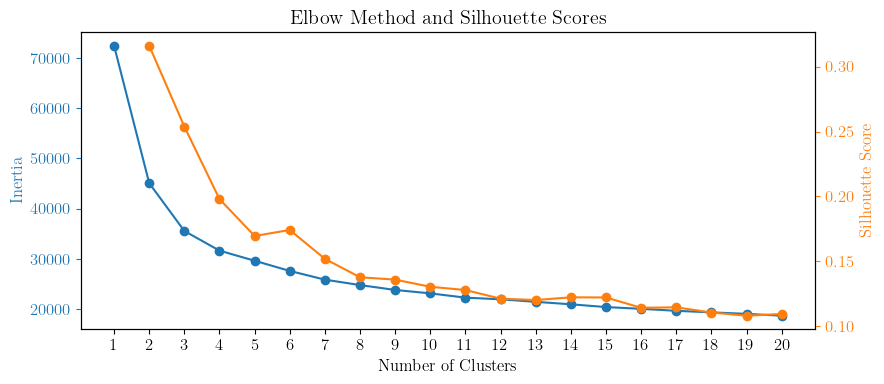

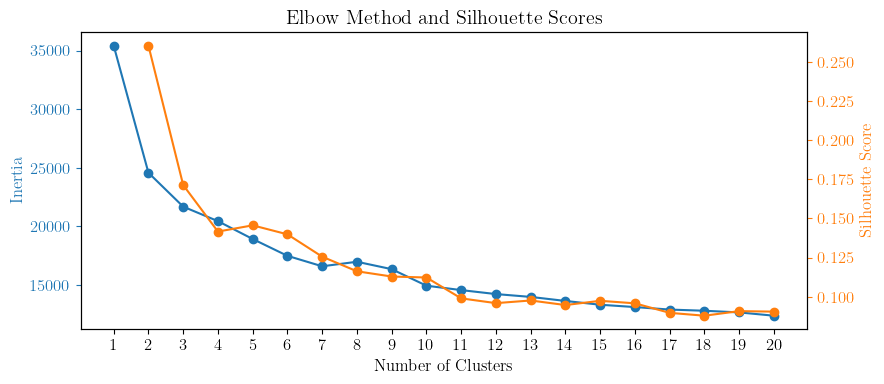

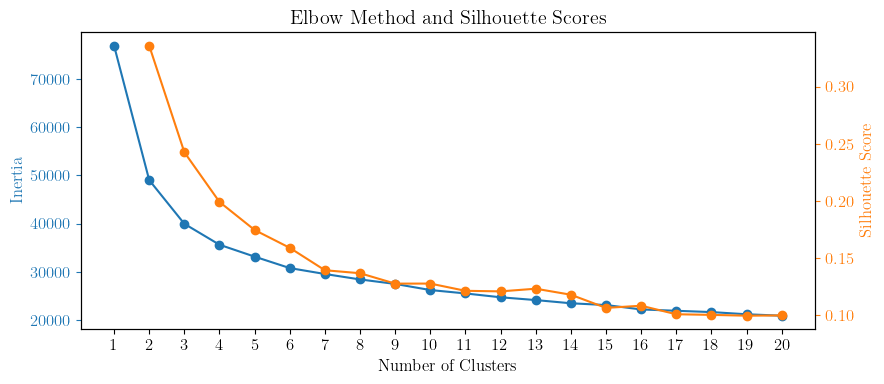

In [274]:
cluster_A_data = flattened_data_bior22_unscaled[labels_DTW_bior22_unscaled == 0]
cluster_B_data = flattened_data_bior22_unscaled[labels_DTW_bior22_unscaled == 1]
cluster_C_data = flattened_data_bior22_unscaled[labels_DTW_bior22_unscaled == 2]

elbow_silhouette_plot(cluster_A_data)
elbow_silhouette_plot(cluster_B_data)
elbow_silhouette_plot(cluster_C_data)

In [300]:
model_DTW_bior22_unscaled_cluster_C = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, n_jobs=-1, init='k-means++').fit(cluster_C_data)
labels_DTW_bior22_unscaled_cluster_C = model_DTW_bior22_unscaled_cluster_C.labels_


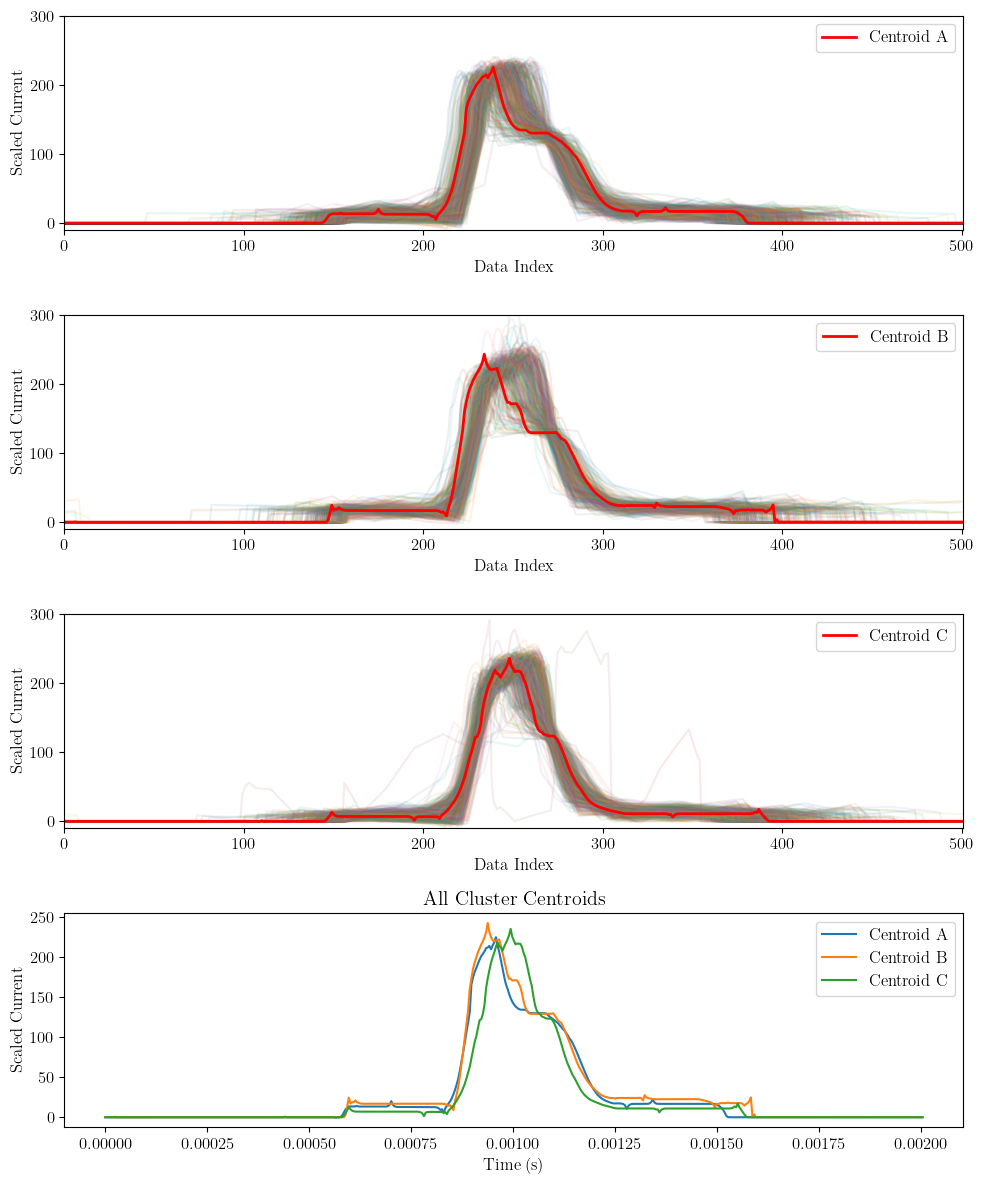

In [301]:
plot_timeseriesKMeans(3, cluster_C_data, model = model_DTW_bior22_unscaled_cluster_C, labels = labels_DTW_bior22_unscaled_cluster_C, ylim = (-10, 300))

In [275]:
model_DTW_bior22_unscaled_cluster_B = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, n_jobs=-1, init='k-means++').fit(cluster_B_data)
labels_DTW_bior22_unscaled_cluster_B = model_DTW_bior22_unscaled_cluster_B.labels_


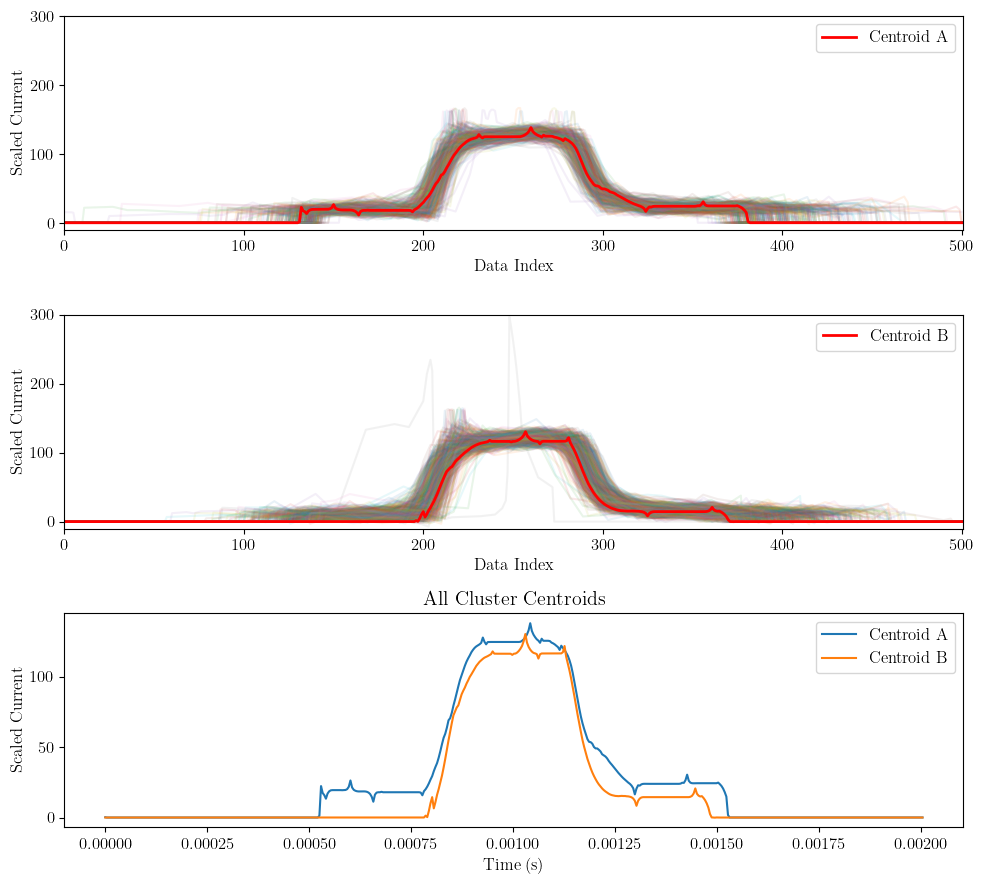

In [276]:
plot_timeseriesKMeans(2, cluster_B_data, model = model_DTW_bior22_unscaled_cluster_B, labels = labels_DTW_bior22_unscaled_cluster_B, ylim = (-10, 300))

In [290]:
model_DTW_bior22_unscaled_cluster_A = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, n_jobs=-1, init='k-means++').fit(cluster_A_data)
labels_DTW_bior22_unscaled_cluster_A = model_DTW_bior22_unscaled_cluster_A.labels_


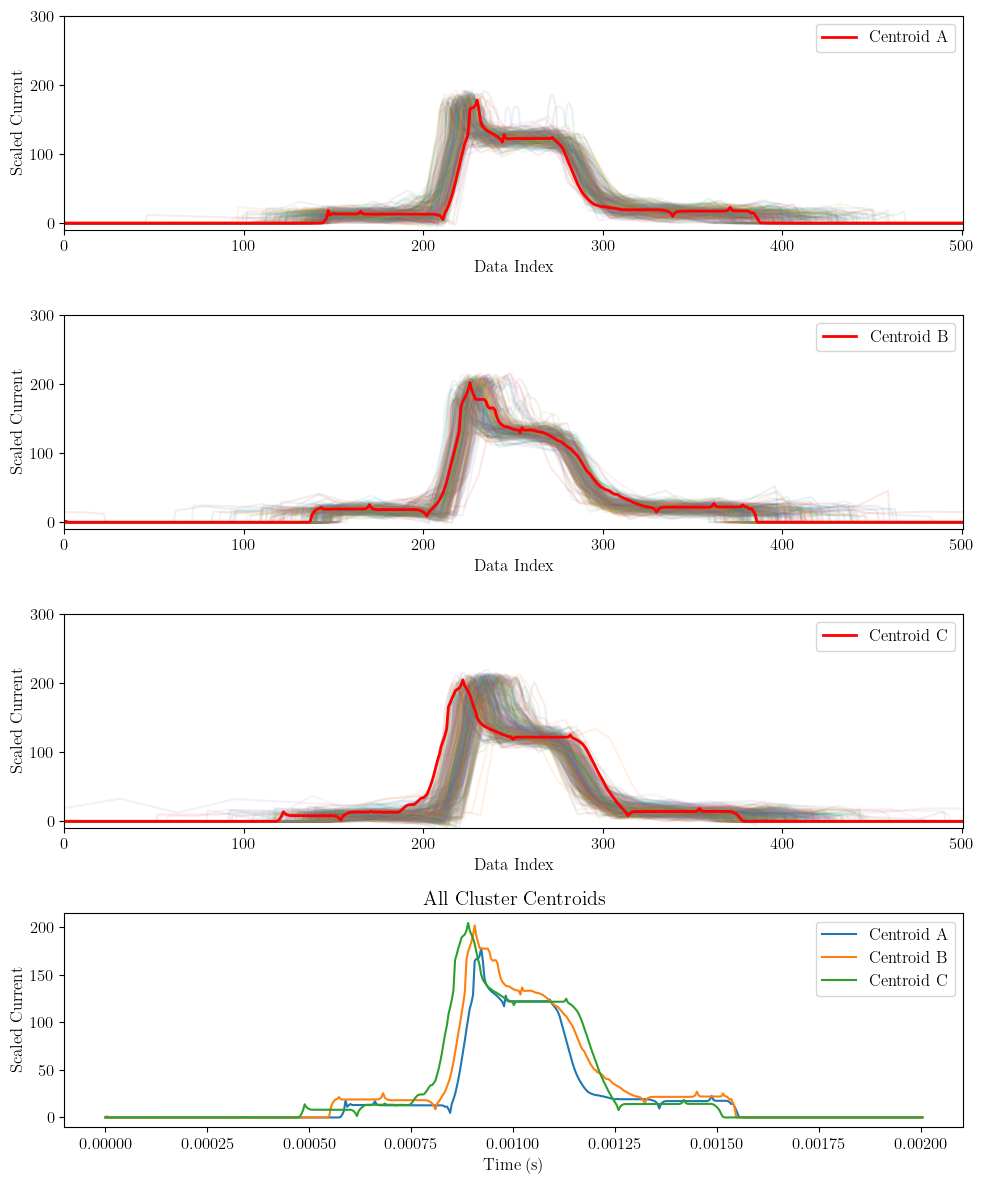

In [291]:
plot_timeseriesKMeans(3, cluster_A_data, model = model_DTW_bior22_unscaled_cluster_A, labels = labels_DTW_bior22_unscaled_cluster_A, ylim = (-10, 300))

In [254]:
len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 0]), len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 1]), len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 2])

(1036, 1241, 887)

In [249]:
for cluster in model_DTW_bior22_unscaled.cluster_centers_:
    print(find_dwell_time_FWHM(np.linspace(0, 501 * 4e-6, 501), cluster.ravel(), "peak-only"))

0.00038476800000000007
0.00017635200000000006
0.0002084159999999999


In [30]:
def plot_timeseriesKMeans_individual(num_clusters, flattened_data, model = None, labels = None, file_name = None, ylim = None, xlim = None):
    if model is None or labels is None:
        model = models_dic[f"n={num_clusters}"]
        labels = labels_dic[f"n={num_clusters}"]

    alphabet = ["A", "B", "C"]
    # Set up the subplot grid: one row for each cluster and one for the centroids
    for cluster_idx in range(num_clusters):
        plt.figure(figsize=(6, 3))#, dpi = 300)

        #colours = ["tab:purple", "tab:gray", "tab:olive"]
        #colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
        # Plot each time series in the cluster
        for series in flattened_data[labels == cluster_idx]:
            plt.plot(series.ravel(), alpha=0.1)#, color=colours[cluster_idx])

        # Plot the centroid
        plt.plot(model.cluster_centers_[cluster_idx].ravel(), color='red', linewidth=2, label = f'Centroid {alphabet[cluster_idx]}')
        plt.xlabel("Data Index")
        plt.ylabel("Current (pA)")
        plt.legend()
        if ylim:
            plt.ylim(ylim[0], ylim[1])
        if xlim:
            plt.xlim(xlim[cluster_idx][0], xlim[cluster_idx][1])
        else:
            plt.xlim(0, len(series.ravel()))
        plt.tight_layout()
        if file_name:
            plt.savefig("MSci_python_images/" + file_name + f"_{cluster_idx}.png", dpi = 300)
        plt.show()

    plt.figure(figsize=(6, 3))#, dpi = 300)
    for cluster_idx in range(num_clusters):
        
        plt.plot(np.linspace(0, 501* 4e-6 * 1000, 501), model.cluster_centers_[cluster_idx].ravel(), label=f'Centroid {alphabet[cluster_idx]}')

    plt.xlabel("Time (ms)")
    plt.ylabel("Current (pA)")
    plt.legend()
    

    plt.tight_layout()
    if file_name:
        plt.savefig("MSci_python_images/" + file_name + "centroids.png", dpi = 300)
    plt.show()

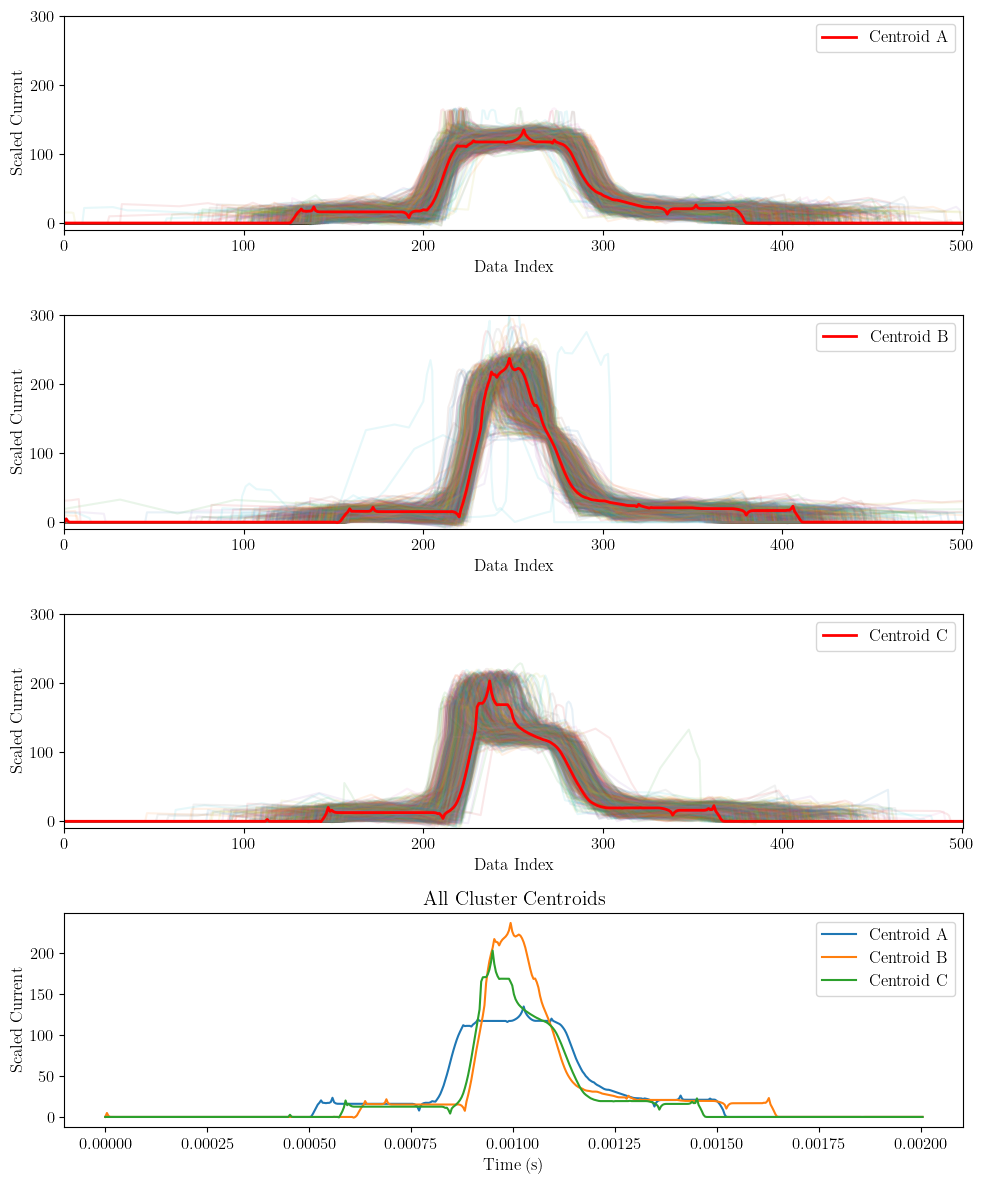

In [183]:
plot_timeseriesKMeans(3, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled, labels = labels_DTW_bior22_unscaled, ylim = (-10, 300))

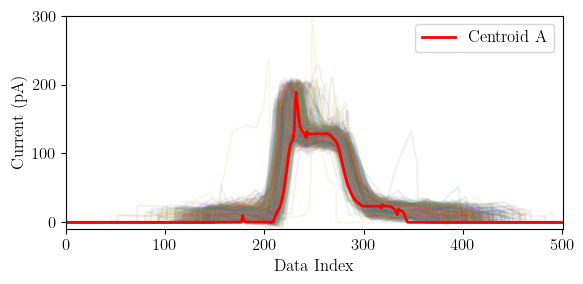

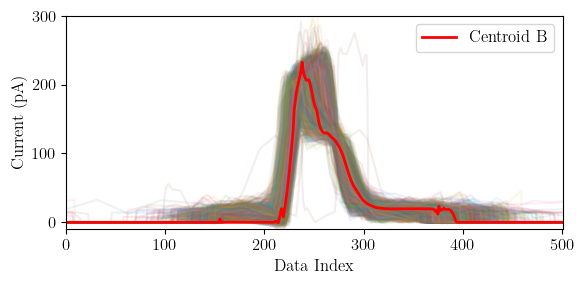

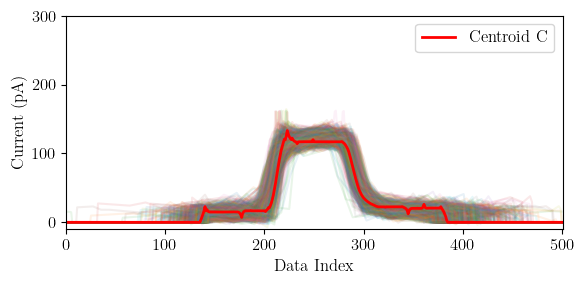

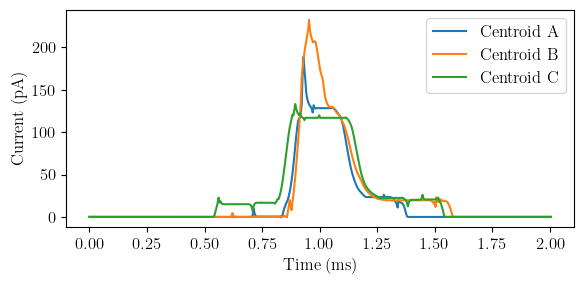

In [780]:
plot_timeseriesKMeans_individual(3, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled, labels = labels_DTW_bior22_unscaled, file_name="KMeans_timeseries_bior22",  ylim = (-10, 300))

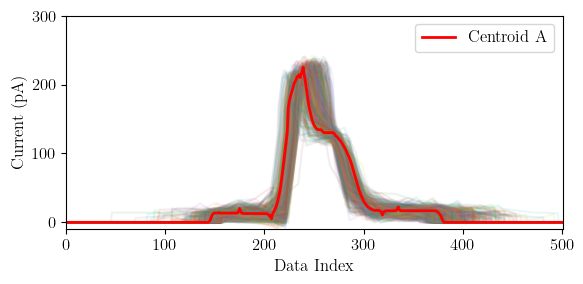

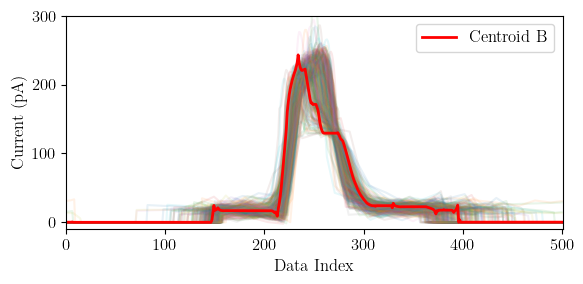

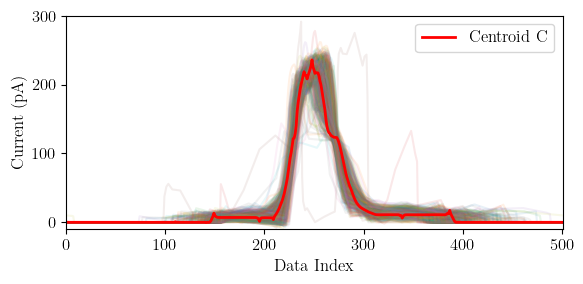

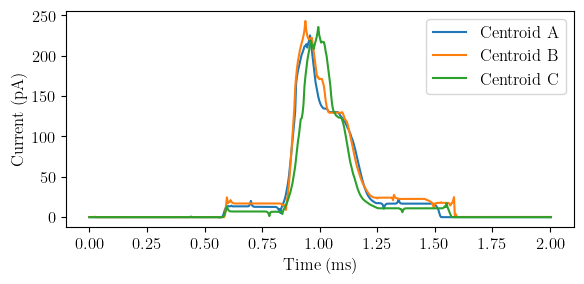

In [304]:
plot_timeseriesKMeans_individual(3, cluster_C_data, model = model_DTW_bior22_unscaled_cluster_C, labels = labels_DTW_bior22_unscaled_cluster_C, file_name="KMeans_timeseries_bior22_centroid_B_", ylim = (-10, 300))

In [19]:
flattened_data_bior22_unscaled2 = np.array(DWT_rec_padded_bior22) 

NameError: name 'DWT_rec_padded_bior22' is not defined

In [22]:
flattened_data_bior22_unscaled_cut = [arr[150:350] for arr in flattened_data_bior22_unscaled]

In [11]:
model_DTW_bior22_unscaled2 = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=10, tol = 1e-9, n_jobs=-1, init='k-means++', random_state=420).fit(flattened_data_bior22_unscaled_cut)
labels_DTW_bior22_unscaled2 = model_DTW_bior22_unscaled2.labels_

In [20]:
model_DTW_bior22_unscaled2 = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=10 , tol = 1e-7, n_jobs=-1, init='k-means++', random_state=420).fit(flattened_data_bior22_unscaled)
labels_DTW_bior22_unscaled2 = model_DTW_bior22_unscaled2.labels_

In [23]:
model_DTW_bior22_unscaled2 = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10 , tol = 1e-7, n_jobs=-1, max_iter_barycenter = 300,  init='k-means++', random_state=420).fit(flattened_data_bior22_unscaled_cut)
labels_DTW_bior22_unscaled2 = model_DTW_bior22_unscaled2.labels_

ValueError: x and y must have same first dimension, but have shapes (501,) and (200,)

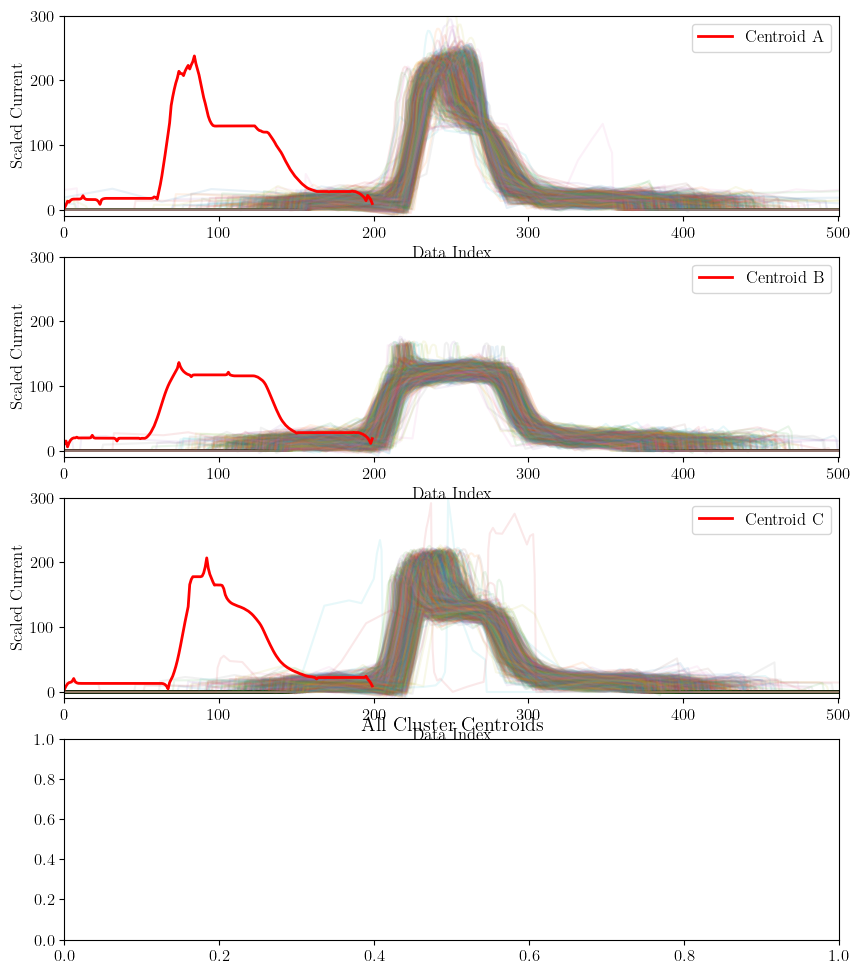

In [24]:
plot_timeseriesKMeans(3, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled2, labels = labels_DTW_bior22_unscaled2, ylim = (-10, 300))

In [ ]:
plot_timeseriesKMeans_individual(3, flattened_data_bior22_unscaled, model = model_DTW_bior22_unscaled2, labels = labels_DTW_bior22_unscaled2,  ylim = (-10, 300), xlim=[(200, 350), (0, 100), (0, 100)])

In [797]:
len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 0]), len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 1]), len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 2])

(599, 1559, 1006)

In [377]:
from scipy.stats import gaussian_kde

def plot_timeseriesKMeans_blur(num_clusters, flattened_data, model=None, labels=None, file_name=None, ylim=None):
    if model is None or labels is None:
        model = models_dic[f"n={num_clusters}"]
        labels = labels_dic[f"n={num_clusters}"]

    # Set up the subplot grid: one row for each cluster and one for the centroids
    fig, axs = plt.subplots(num_clusters + 1, 1, figsize=(10, 3 * (num_clusters + 1)))

    for cluster_idx in range(num_clusters):
        axs[cluster_idx].set_title(f"Cluster {cluster_idx + 1}")
        cluster_data = flattened_data[labels == cluster_idx]
        
        # Using Gaussian KDE for each time point to get a smooth density
        for time_point in range(cluster_data.shape[1]):
            time_series_at_point = cluster_data[:, time_point]
            density = gaussian_kde(time_series_at_point)
            x = np.linspace(min(time_series_at_point), max(time_series_at_point), 100)
            axs[cluster_idx].fill_between(x, density(x), alpha=0.5)

        # Plot the centroid
        axs[cluster_idx].plot(model.cluster_centers_[cluster_idx].ravel(), color='red', linewidth=2, label=f"Cluster centroid {cluster_idx + 1}")
        axs[cluster_idx].set_xlabel("Data Index")
        axs[cluster_idx].set_ylabel("Scaled Current")
        axs[cluster_idx].legend()
        if ylim:
            axs[cluster_idx].set_ylim(ylim[0], ylim[1])

    # Plot all centroids in the last subplot
    axs[num_clusters].set_title("All Cluster Centroids")
    for cluster_idx in range(num_clusters):
        axs[num_clusters].plot(model.cluster_centers_[cluster_idx].ravel(), label=f'Centroid {cluster_idx + 1}')

    axs[num_clusters].set_xlabel("Time (s)")
    axs[num_clusters].set_ylabel("Scaled Current")
    axs[num_clusters].legend()

    plt.tight_layout()
    if file_name:
        plt.savefig(file_name + ".png", dpi=300)
    plt.show()


##### KMeans with features
- KMeans can struggle when the clusters aren't sphereically shaped

In [ ]:
features  =

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler((-1,1))

features_scaled = scaler.fit_transform(features) # feaures array shape (n_samples, n_features)

pca = PCA(n_components=2)

features_pca = pca.fit_transform(features_scaled)

/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for 3 clusters: 0.4196877938601759
Cluster centroids:
 [[ 1.0159  0.1081 -0.0053 ... -0.0732  0.0172  0.0124]
 [-0.7151 -0.8478  0.0343 ...  0.0262 -0.0427 -0.0179]
 [-1.4329  1.2223 -0.0469 ...  0.1486  0.0304 -0.0013]]


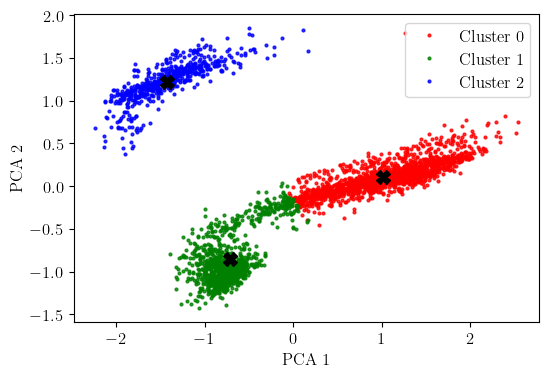

In [3]:
#scaler = MaxAbsScaler()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MinMaxScaler((-1,1))
#scaler = RobustScaler()

X_scaled = scaler.fit_transform(df_all_wavelets_02_DNA["bior2.2"][0])

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, init = 'k-means++', max_iter=1000)
kmeans.fit(X_pca)

silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")
centroids = kmeans.cluster_centers_
# You can also examine the cluster centroids
print("Cluster centroids:\n", centroids)

# Assigning labels to your original dataset if needed
labels_kmeans = kmeans.labels_

plt.figure(figsize=(6, 4))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'tab:orange'] # Add more colors if you have more clusters

# Plot each cluster
for i in range(centroids.shape[0]):
    # Select only data points with the cluster label == i
    ds = X_pca[np.where(labels_kmeans == i)]
    # Plot the data points
    plt.plot(ds[:, 0], ds[:, 1], 'o', markersize=2, color=colors[i], label=f'Cluster {i}', alpha = 0.8)
    # Plot the centroid
    plt.plot(centroids[i][0], centroids[i][1], 'kX', markersize=10, markeredgewidth=1)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc = "upper right")
plt.show()

In [10]:
sklearn.preprocessing.scale(df_all_wavelets_02_DNA["bior2.2"][0])

/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


array([[-0.8967,  1.6084, -1.5334, ..., -0.0068,  0.6105, -0.8259],
       [ 0.823 , -0.8391,  0.825 , ...,  0.6543, -1.0689,  0.9908],
       [ 0.6755, -0.213 ,  0.2126, ..., -0.7117,  0.3595, -0.5818],
       ...,
       [ 0.059 ,  0.9254, -0.9341, ...,  0.1694,  0.4137, -0.5803],
       [-1.1363,  1.0962, -1.2209, ..., -0.5738,  0.6267, -1.0378],
       [ 0.7643, -0.9529,  0.7666, ...,  0.9139, -0.1356,  0.6297]])

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, init = 'k-means++', max_iter=1000)
kmeans.fit(features_scaled)

centroids = kmeans.cluster_centers_

labels_kmeans = kmeans.labels_

In [4]:
#scaler = MaxAbsScaler()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MinMaxScaler((-1,1))
#scaler = RobustScaler()

X_scaled = scaler.fit_transform(df_all_wavelets_02_DNA["bior2.2"][0])

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, init = 'k-means++', max_iter=1000)
kmeans.fit(X_pca_filtered)

centroids = kmeans.cluster_centers_
# You can also examine the cluster centroids
print("Cluster centroids:\n", centroids)

# Assigning labels to your original dataset if needed
labels_kmeans = kmeans.labels_

plt.figure(figsize=(6, 4))
colors = ["tab:orange", "tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"] # Add more colors if you have more clusters
# Plot each cluster

for i in range(centroids.shape[0]):
    # Select only data points with the cluster label == i
    ds = X_pca_filtered[np.where(labels_kmeans[:-1] == i)]
    # Plot the data points
    plt.scatter(ds[:, 0], ds[:, 1], s=30, linewidths=0.2, edgecolor='k', color=colors[i], label=f'Cluster {i}')
    # Plot the centroid
    plt.scatter(centroids[i][0], centroids[i][1], marker='X', color = 'k', s=100, edgecolor='w')

legend_handles = [mpatches.Patch(color=colours[0], label='Cluster 0'),
                  mpatches.Patch(color=colours[1], label='Cluster 1'),
                  mpatches.Patch(color=colours[2], label='Cluster 2')]
legend_handles.append(Line2D([0], [0], marker='X', color='w', label='Centroids', 
                             markerfacecolor='k', markersize=10))

plt.legend(handles=legend_handles, loc="upper right")

plt.xlabel(f'PC 1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}$\%$ variance explained)')
plt.ylabel(f'PC 2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}$\%$ variance explained)')
plt.tight_layout()
#plt.xlim(-2, 3)
plt.ylim(-2, 3)

plt.tight_layout()
#plt.savefig("MSci_python_images/DNA_KMeans_attempt_clustering_bior22.png", dpi=500)
plt.show()

NameError: name 'X_pca_filtered' is not defined

optimal number of KMeans clusters

In [5]:
models_dic_kmeans = {}
labels_dic_kmeans = {}

num_clusters_range_kmeans = range(1, 20)

# DataFrame to store results
results_df_kmeans = pd.DataFrame(columns=["Num_Clusters", "Inertia", "Silhouette_Score"])

# Loop through each cluster size
for n_clusters in num_clusters_range_kmeans:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, init = "k-means++")
    kmeans.fit(X_pca)
    
    # Store model and labels
    models_dic_kmeans[f"n={n_clusters}"] = kmeans
    labels_dic_kmeans[f"n={n_clusters}"] = kmeans.labels_
    
    # Calculate inertia
    inertia = kmeans.inertia_
    
    # Calculate silhouette score, handling the case where n_clusters = 1
    if n_clusters == 1:
        silhouette_avg = None
    else:
        #silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
    
    # Store results
    results_df_kmeans.loc[n_clusters-1] = [n_clusters, inertia, silhouette_avg]


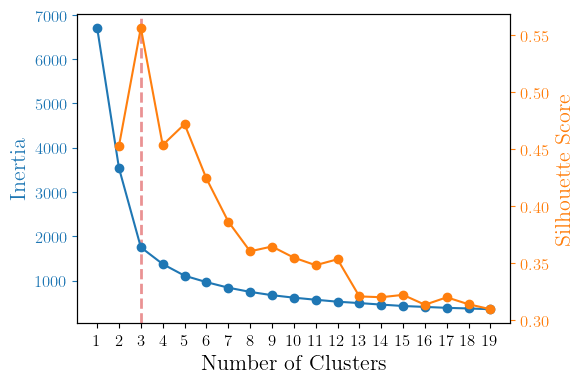

In [15]:
fig, ax1 = plt.subplots(figsize=(6, 4))

plt.axvline(x=3, color='tab:red', linestyle='--', linewidth=2, alpha  =0.5, label = "Optimal number of clusters")

# Plotting Inertia on the left y-axis
ax1.plot(results_df_kmeans["Num_Clusters"], results_df_kmeans["Inertia"], color='#1f77b4', marker='o')
ax1.set_xlabel('Number of Clusters', fontsize = 16)
ax1.set_ylabel('Inertia', color='#1f77b4', fontsize = 16)
ax1.tick_params('y', colors='#1f77b4')
ax1.set_xticks(num_clusters_range_kmeans)

# Create another y-axis for the Silhouette Score
ax2 = ax1.twinx()
ax2.plot(results_df_kmeans["Num_Clusters"], results_df_kmeans["Silhouette_Score"], color='#ff7f0e', marker='o')
ax2.set_ylabel('Silhouette Score', color='#ff7f0e', fontsize = 16)
ax2.tick_params('y', colors="#ff7f0e")

# Setting titles and layout
#plt.xlim(0,10)
#plt.title('Elbow Method and Silhouette Scores')

plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/DNA_KMeans_features_elbowsil_bior22_20_6_4_ratio.png", dpi=500)
plt.show()


##### Agglomerative clustering
- The agglomerative clustering is the most common type of hierarchical clustering used to group objects in clusters based on their similarity
- It’s also known as AGNES (Agglomerative Nesting)

In [7]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.patches as mpatches

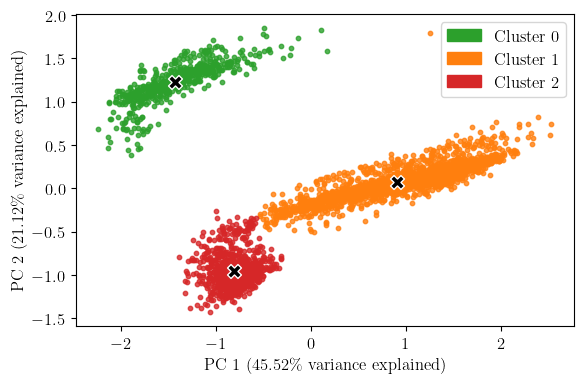

In [9]:
from sklearn.cluster import AgglomerativeClustering

scaler = MinMaxScaler((-1,1))
#scaler = RobustScaler()

X_scaled = scaler.fit_transform(df_all_wavelets_02_DNA["bior2.2"][0])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


agglomerative = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglomerative.fit_predict(X_pca)

centroids_agglo = np.array([X_pca[labels_agglo == i].mean(axis=0) for i in range(agglomerative.n_clusters)])


cluster_sizes = [(i, np.sum(labels_agglo == i)) for i in range(agglomerative.n_clusters)]
sorted_by_size = sorted(cluster_sizes, key=lambda x: x[1], reverse=True)

# Assign colors and new labels based on size
color_and_label = {sorted_by_size[0][0]: ('tab:orange', 'Cluster 1'),
                   sorted_by_size[1][0]: ('tab:red', 'Cluster 2'),
                   sorted_by_size[2][0]: ('tab:green', 'Cluster 0')}

# Plotting with assigned colors and labels
plt.figure(figsize=(6, 4))
for original_label, (color, new_label) in color_and_label.items():
    ds = X_pca[labels_agglo == original_label]
    plt.scatter(ds[:, 0], ds[:, 1], s=10, color=color, alpha=0.8)
    
for i in range(len(centroids_agglo)):
    centroid = centroids_agglo[i]
    plt.scatter(centroid[0], centroid[1], color='k', marker='X', s=100, edgecolor='w')


# Manually create legend handles in the desired order
legend_handles = [mpatches.Patch(color='tab:green', label='Cluster 0'),
                  mpatches.Patch(color='tab:orange', label='Cluster 1'),
                  mpatches.Patch(color='tab:red', label='Cluster 2')]

# Adding legend to the plot with specified order of handles
plt.legend(handles=legend_handles, loc="upper right")
plt.xlabel(f'PC 1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}$\%$ variance explained)')
plt.ylabel(f'PC 2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}$\%$ variance explained)')
plt.tight_layout()
#plt.savefig("MSci_python_images/DNA_agglo_clustering_bior22.png", dpi=300)
plt.show()

In [34]:
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

original_cmap = plt.cm.get_cmap('Blues')
start = 0  # Higher values make the colormap start from darker shades
stop = 2.0   # Use 1.0 to include the darkest color of the original colormap
darker_blues = LinearSegmentedColormap.from_list(
    'DarkerBlues', 
    to_rgba_array(original_cmap(np.linspace(start, stop, 256))))

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_11222/608383351.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap('Blues')


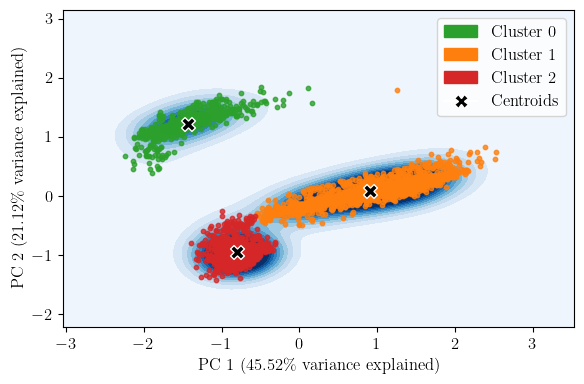

In [35]:
from scipy.stats import gaussian_kde
# import line2D for creating custom legends
from matplotlib.lines import Line2D
x = X_pca[:, 0]
y = X_pca[:, 1]
xy = np.vstack([x, y])

# Create grid for contour
x_min, x_max = x.min() - 0.8, x.max() + 1
y_min, y_max = y.min() - 0.8, y.max() + 1.3
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
zz = gaussian_kde(xy)(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

# Plot setup
fig, ax = plt.subplots(figsize=(6,4))
contour = ax.contourf(xx, yy, zz, levels=np.linspace(zz.min(), zz.max(), 20), cmap=darker_blues, zorder=1, extend='neither')


for original_label, (color, new_label) in color_and_label.items():
    ds = X_pca[labels_agglo == original_label]
    ax.scatter(ds[:, 0], ds[:, 1], s=10, color=color, alpha=0.8)
    
for i in range(len(centroids_agglo)):
    centroid = centroids_agglo[i]
    ax.scatter(centroid[0], centroid[1], color='k', marker='X', s=100, edgecolor='w', label = "Centroid")


# Manually create legend handles in the desired order
legend_handles = [mpatches.Patch(color='tab:green', label='Cluster 0'),
                  mpatches.Patch(color='tab:orange', label='Cluster 1'),
                  mpatches.Patch(color='tab:red', label='Cluster 2')]
legend_handles.append(Line2D([0], [0], marker='X', color='w', label='Centroids', 
                             markerfacecolor='k', markersize=10))
# Adding legend to the plot with specified order of handles
plt.legend(handles=legend_handles, loc="upper right")
plt.xlabel(f'PC 1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}$\%$ variance explained)')
plt.ylabel(f'PC 2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}$\%$ variance explained)')
plt.tight_layout()
#plt.savefig("MSci_python_images/DNA_agglo_clustering_bior22_contour.png", dpi=500)
plt.show()

In [11]:
scaler = MinMaxScaler((-1,1))
#scaler = RobustScaler()

X_scaled = scaler.fit_transform(df_all_wavelets_02_DNA["bior2.2"][0])

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, init = 'k-means++', max_iter=1000)
kmeans.fit(X_pca)

agglomerative = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglomerative.fit_predict(X_pca)

centroids_agglo = np.array([X_pca[labels_agglo == i].mean(axis=0) for i in range(agglomerative.n_clusters)])


/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
condition = ~( (X_pca[:, 0] > 1) & (X_pca[:, 1] > 1.5) )

X_pca_filtered = X_pca[condition]
labels_agglo_filtered = labels_agglo[condition]

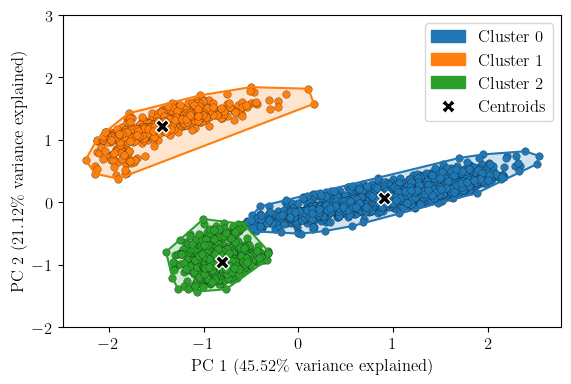

In [120]:
from matplotlib.colors import ListedColormap
from scipy.spatial import ConvexHull

colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:olive", "tab:cyan"]
n_clusters = len(np.unique(labels_agglo_filtered))

plt.figure(figsize=(6, 4))

for i, color in enumerate(colours[:n_clusters]):
    points = X_pca_filtered[labels_agglo_filtered == i]
    
    hull = ConvexHull(points)
    
    plt.scatter(points[:, 0], points[:, 1], c=color, edgecolor='k', s=30, linewidths=0.2, label=f"Cluster {i}")
    
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], color=color, alpha=0.2)  # Fill the convex hull with a transparent color

for i in range(len(centroids_agglo)):
    centroid = centroids_agglo[i]
    plt.scatter(centroid[0], centroid[1], color='k', marker='X', s=100, edgecolor='w', label = "Centroid")



legend_handles = [mpatches.Patch(color=colours[0], label='Cluster 0'),
                  mpatches.Patch(color=colours[1], label='Cluster 1'),
                  mpatches.Patch(color=colours[2], label='Cluster 2')]
legend_handles.append(Line2D([0], [0], marker='X', color='w', label='Centroids', 
                             markerfacecolor='k', markersize=10))

plt.legend(handles=legend_handles, loc="upper right")

plt.xlabel(f'PC 1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}$\%$ variance explained)')
plt.ylabel(f'PC 2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}$\%$ variance explained)')
plt.tight_layout()
#plt.xlim(-2, 3)
plt.ylim(-2, 3)
#plt.title('Cluster Plot with Convex Hulls')
#plt.savefig("MSci_python_images/DNA_PCA_agglo_clustering_convexhull.png", dpi=500)
plt.show()


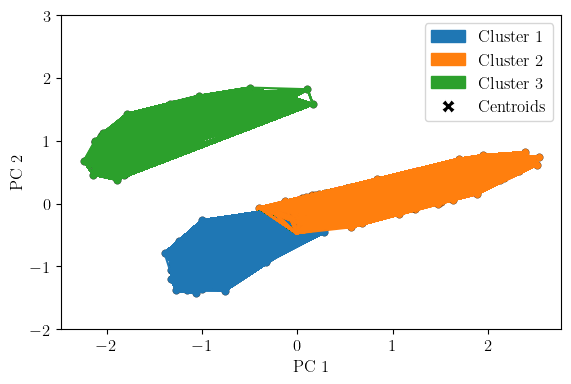

In [14]:
from matplotlib.colors import ListedColormap
from scipy.spatial import ConvexHull
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:olive", "tab:cyan"]
n_clusters = len(np.unique(labels_agglo_filtered))

plt.figure(figsize=(6, 4))

for i, color in enumerate(colours[:n_clusters]):
    points = X_pca_filtered[labels_agglo_filtered == i]
    
    hull = ConvexHull(points)
    
    plt.scatter(points[:, 0], points[:, 1], c=color, edgecolor='k', s=30, linewidths=0.2, label=f"Cluster {i}")
    
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], color=color, alpha=0.2)  # Fill the convex hull with a transparent color

for i in range(len(centroids_agglo)):
    centroid = centroids_agglo[i]
    plt.scatter(centroid[0], centroid[1], color='k', marker='X', s=100, edgecolor='w', label = "Centroid")



legend_handles = [mpatches.Patch(color=colours[0], label='Cluster 1'),
                  mpatches.Patch(color=colours[1], label='Cluster 2'),
                  mpatches.Patch(color=colours[2], label='Cluster 3')]
legend_handles.append(Line2D([0], [0], marker='X', color='w', label='Centroids', 
                             markerfacecolor='k', markersize=10))

plt.legend(handles=legend_handles, loc="upper right")

plt.xlabel(f'PC 1')
plt.ylabel(f'PC 2 ')
plt.tight_layout()
#plt.xlim(-2, 3)
plt.ylim(-2, 3)
#plt.title('Cluster Plot with Convex Hulls')
#plt.savefig("MSci_python_images/DNA_PCA_agglo_clustering_convexhull.png", dpi=500)
plt.show()

In [5]:
from matplotlib.colors import ListedColormap
colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:olive", "tab:cyan"]
custom_cmap = ListedColormap(colours[:len(centroids_agglo)])

Optimal number of clusters for agglo

In [11]:
#import cdist
from scipy.spatial.distance import cdist

In [1]:
num_clusters_range = range(1, 21)
wcss_agglo = []
silhouette_scores_agglo = []

for k in num_clusters_range:
    model_agglo = AgglomerativeClustering(n_clusters=k)
    labels_agglo_k = model_agglo.fit_predict(X_pca)
    centroids_agglo_k = np.array([X_pca[labels_agglo_k == i].mean(axis=0) for i in range(k)])
    
    wcss = sum(np.min(cdist(X_pca, centroids_agglo_k, 'euclidean'), axis=1)) / X_pca.shape[0]
    wcss_agglo.append(wcss)

    if k == 1:
        silhouette_scores_agglo.append(None)
    else:
        silhouette_avg_agglo = silhouette_score(X_pca, labels_agglo_k)
        silhouette_scores_agglo.append(silhouette_avg_agglo)
    
#fig, ax1 = plt.subplots(figsize=(9, 4))
fig, ax1 = plt.subplots(figsize=(6, 4))

plt.axvline(x=3, color='tab:red', linestyle='--', linewidth=2, alpha  =0.5, label = "Optimal number of clusters")
plt.legend()

ax1.plot(num_clusters_range, wcss_agglo, color='#1f77b4', marker='o', label='WCSS')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='#1f77b4')
ax1.tick_params('y', colors='#1f77b4')
ax1.set_xticks(num_clusters_range)


ax2 = ax1.twinx()
ax2.plot(num_clusters_range, silhouette_scores_agglo, color='#ff7f0e', marker='o', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='#ff7f0e')
ax2.tick_params('y', colors="#ff7f0e")

plt.tight_layout()
#plt.savefig("MSci_python_images/DNA_agglo_clustering_bior22_elbow_20_6_4.png", dpi=500)
plt.show()

NameError: name 'AgglomerativeClustering' is not defined

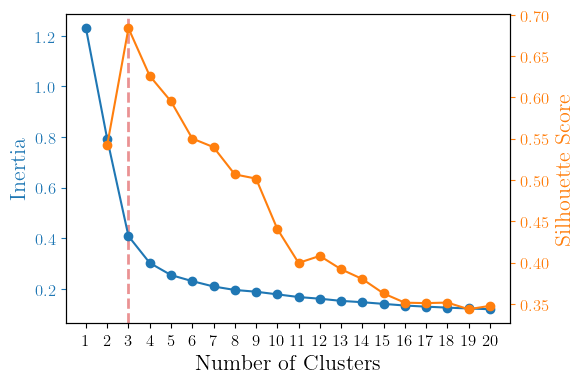

In [14]:
num_clusters_range = range(1, 21)
wcss_agglo = []
silhouette_scores_agglo = []

for k in num_clusters_range:
    model_agglo = AgglomerativeClustering(n_clusters=k)
    labels_agglo_k = model_agglo.fit_predict(X_pca)
    centroids_agglo_k = np.array([X_pca[labels_agglo_k == i].mean(axis=0) for i in range(k)])
    
    wcss = sum(np.min(cdist(X_pca, centroids_agglo_k, 'euclidean'), axis=1)) / X_pca.shape[0]
    wcss_agglo.append(wcss)

    if k == 1:
        silhouette_scores_agglo.append(None)
    else:
        silhouette_avg_agglo = silhouette_score(X_pca, labels_agglo_k)
        silhouette_scores_agglo.append(silhouette_avg_agglo)
    
#fig, ax1 = plt.subplots(figsize=(9, 4))
fig, ax1 = plt.subplots(figsize=(6, 4))

plt.axvline(x=3, color='tab:red', linestyle='--', linewidth=2, alpha  =0.5, label = "Optimal number of clusters")

ax1.plot(num_clusters_range, wcss_agglo, color='#1f77b4', marker='o', label='WCSS')
ax1.set_xlabel('Number of Clusters', fontsize = 16)
ax1.set_ylabel('Inertia', color='#1f77b4', fontsize = 16)
ax1.tick_params('y', colors='#1f77b4')
ax1.set_xticks(num_clusters_range)


ax2 = ax1.twinx()
ax2.plot(num_clusters_range, silhouette_scores_agglo, color='#ff7f0e', marker='o', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='#ff7f0e', fontsize = 16)
ax2.tick_params('y', colors="#ff7f0e")

plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/DNA_agglo_clustering_bior22_elbow_20_6_4.png", dpi=500)
plt.show()

In [286]:
len(X_pca[labels_agglo == 0]), len(X_pca[labels_agglo == 1]), len(X_pca[labels_agglo == 2])

(1664, 919, 581)

In [287]:
centroids_original_space2 = pca.inverse_transform(centroids_agglo)
centroids_unscaled2 = scaler.inverse_transform(centroids_original_space2)

In [288]:
centroids_unscaled2

array([[    222.6564,       0.0002,       2.5149, ..., 1829371.5671,
             -1.1849,       4.3264],
       [    147.9203,       0.0003,       1.667 , ..., 1277030.3298,
              1.6654,       2.0328],
       [    182.0285,       0.0003,       1.8751, ..., 1379483.695 ,
              1.2899,       2.3548]])

In [728]:
len(X_pca[labels_agglo == 0]), len(X_pca[labels_agglo == 1]), len(X_pca[labels_agglo == 2])

(1728, 970, 466)

In [815]:
print(len(X_pca[labels_agglo == 0]), len(X_pca[labels_agglo == 1]), len(X_pca[labels_agglo == 2]))
total_no_evetns = len(labels_agglo)
print("%", len(X_pca[labels_agglo == 0])/total_no_evetns * 100, len(X_pca[labels_agglo == 1])/total_no_evetns * 100, len(X_pca[labels_agglo == 2])/total_no_evetns * 100)

1728 970 466
% 54.614412136536025 30.65739570164349 14.72819216182048


In [798]:
len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 0]), len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 1]), len(labels_DTW_bior22_unscaled[labels_DTW_bior22_unscaled == 2])

(599, 1559, 1006)

- 1728, 970, 466
- 1559, 1006, 599

In [729]:
centroids_original_space = pca.inverse_transform(centroids_agglo)
centroids_unscaled = scaler.inverse_transform(centroids_original_space)

In [730]:
features_df_bior22

deltaI_c  dwell_time      skew  kurtosis  conductive_area  no_peaks  \
0     140.474097    0.000380  1.390396  0.297955         0.063671         1   
1     225.290000    0.000188  2.550765  5.494153         0.049569         1   
2     219.590000    0.000228  2.270996  4.277024         0.048014         1   
3     226.650000    0.000172  2.732540  6.282897         0.050369         1   
4     235.160000    0.000168  2.712022  6.217498         0.053596         1   
...          ...         ...       ...       ...              ...       ...   
3159  233.100000    0.000172  2.732492  6.464510         0.053308         1   
3160  227.690000    0.000168  2.746163  6.383047         0.052679         1   
3161  195.770000    0.000312  1.723157  1.538435         0.060816         2   
3162  131.004235    0.000344  1.533548  0.824479         0.055731         1   
3163  223.020000    0.000184  2.505933  5.265364         0.053364         1   

      peak_lower_delta_I  peak_pos_rel   entropy       mean  ...  \
0             140.474097      0.459082  2.962072  31.772148  ...   
1             225.290000      0.453094  2.424600  24.735156  ...   
2             219.590000      0.439122  2.518022  23.959252  ...   
3             226.650000      0.465070  2.469196  25.134141  ...   
4             235.160000      0.471058  2.300855  26.744510  ...   
...                  ...           ...       ...        ...  ...   
3159          233.100000      0.459082  2.484286  26.600589  ...   
3160          227.690000      0.465070  2.427436  26.286696  ...   
3161          137.744810      0.397206  2.787963  30.347494  ...   
3162          131.004235      0.502994  2.654868  27.810080  ...   
3163          223.020000      0.463074  2.543971  26.628547  ...   

         min_deriv  sum_absolute_changes  sign_changes_sum  decay_time_lhs  \
0    -2.177070e+06          8.942788e+07                15             0.0   
1    -4.272500e+06          1.329943e+08                12             0.0   
2    -4.272500e+06          1.268010e+08                 9             0.0   
3    -5.147495e+06          1.348938e+08                12             0.0   
4    -7.320424e+06          1.423310e+08                17             0.0   
...            ...                   ...               ...             ...   
3159 -6.488388e+06          1.276227e+08                10             0.0   
3160 -4.577500e+06          1.361670e+08                12             0.0   
3161 -3.995872e+06          1.070491e+08                11             0.0   
3162 -1.997423e+06          7.234676e+07                 9             0.0   
3163 -4.073359e+06          1.340181e+08                15             0.0   

      decay_time_rhs  approx_mean   approx_sd  approx_energy  \
0           0.000192   286.557516  276.161676   1.583805e+06   
1           0.000184   304.424494  410.838734   1.830239e+06   
2           0.000224   297.827761  316.251784   1.321016e+06   
3           0.000084   278.176835  426.276925   2.072755e+06   
4           0.000096   326.118774  454.607248   2.191148e+06   
...              ...          ...         ...            ...   
3159        0.000136   286.882281  382.607422   1.829519e+06   
3160        0.000096   285.845394  427.319441   2.114476e+06   
3161        0.000292   300.324004  305.091482   1.649478e+06   
3162        0.000176   308.137927  276.775097   1.372427e+06   
3163        0.000120   300.856854  387.762502   1.926997e+06   

      spectral_entropy  band_power  
0             1.256403    2.179931  
1            -1.931848    4.639650  
2             0.779923    2.510432  
3            -1.304679    5.109193  
4            -5.135589    6.133424  
...                ...         ...  
3159         -0.823235    4.084873  
3160         -1.243989    5.057225  
3161          0.882894    2.512517  
3162          1.287310    1.893011  
3163         -0.160032    4.150780  

[3164 rows x 24 columns]

In [731]:
features_df_bior22.keys()

Index(['deltaI_c', 'dwell_time', 'skew', 'kurtosis', 'conductive_area',
       'no_peaks', 'peak_lower_delta_I', 'peak_pos_rel', 'entropy', 'mean',
       'std', 'var', 'rms', 'max_deriv', 'min_deriv', 'sum_absolute_changes',
       'sign_changes_sum', 'decay_time_lhs', 'decay_time_rhs', 'approx_mean',
       'approx_sd', 'approx_energy', 'spectral_entropy', 'band_power'],
      dtype='object')

In [732]:
centroids_unscaled

array([[    221.3541,       0.0002,       2.5019, ..., 1795629.1759,
             -0.8612,       4.136 ],
       [    132.1031,       0.0003,       1.6088, ..., 1302930.8836,
              1.3378,       2.1828],
       [    187.6023,       0.0003,       1.9375, ..., 1400118.0567,
              1.0705,       2.5132]])

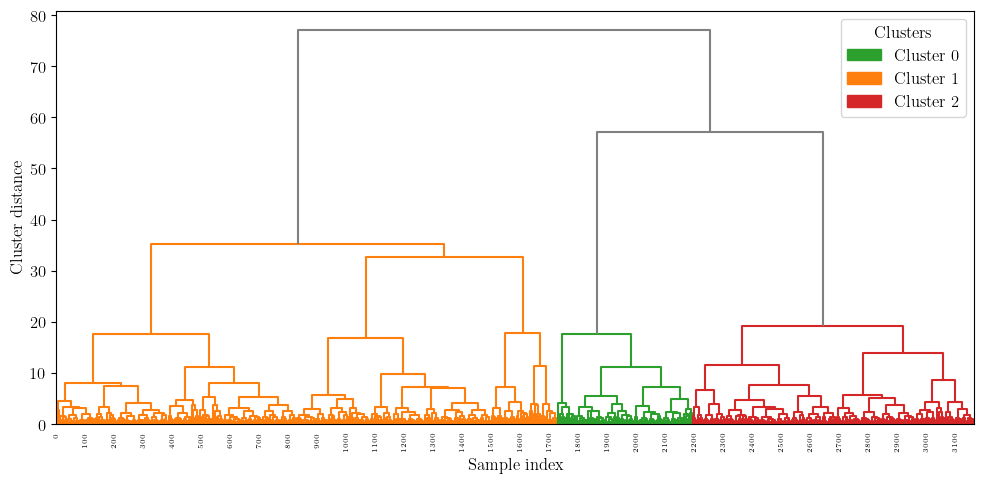

In [784]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_pca, 'ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 5))
dendrogram_result = dendrogram(Z, color_threshold=0.7 * max(Z[:, 2]), above_threshold_color='gray')

unique_colors = set(dendrogram_result['color_list'])
unique_colors.discard('gray')  # Removing 'gray' as it's used for dendrogram branches above the color threshold


color_legend = {color: f"Cluster {i}" for i, color in enumerate(unique_colors)}

# Adding a custom legend to the plot
from matplotlib.patches import Patch
legend_handles = [Patch(color=color, label=label) for color, label in color_legend.items()]
plt.legend(handles=legend_handles, title="Clusters")

x_ticks = np.arange(0,len(dendro['leaves'])*10, 1000)
plt.xticks(ticks=x_ticks, labels=[int(x/10) for x in x_ticks])

plt.xlabel('Sample index')
plt.ylabel('Cluster distance')
plt.tight_layout()

plt.savefig("MSci_python_images/DNA_Dendrogram_agglo_clustering_bior22.png", dpi=300)
plt.show()

PCA loadings

In [97]:
features_names = ["$\Delta I_c$", "Dwell time", "Skew", "kurtosis", "Conductive_area", "no_peaks", "Primary peak $\Delta$ $I_c$", "Peak position", "entropy", "mean", "std", "var", "rms", "max_deriv", "min_deriv", "sum_absolute_changes", "$\sum$ Sign changes", "decay_time_lhs", "RHS decay const.", "approx_mean", "std (approx)", "approx_energy", "spectral_entropy", "Band power"]


In [57]:
color_and_label = {sorted_by_size[0][0]: ('tab:orange', 'Cluster 1'),
                   sorted_by_size[1][0]: ('tab:red', 'Cluster 2'),
                   sorted_by_size[2][0]: ('tab:green', 'Cluster 0')}

In [87]:
feature_importances = np.sqrt(np.sum(pca.components_[:2, :]**2, axis=0))

# Sort features by their importances, descending
sorted_indices = np.argsort(feature_importances)[::-1][:10]

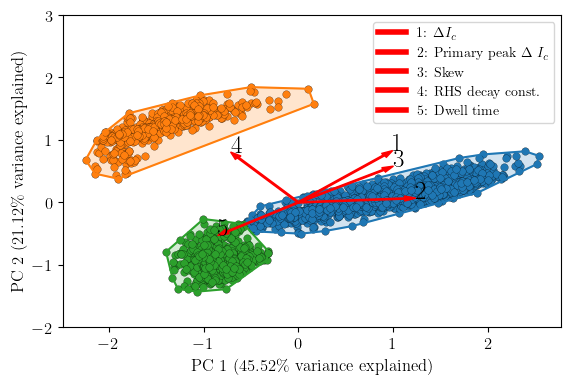

In [100]:
from matplotlib.colors import ListedColormap
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Assuming 'X_pca_filtered', 'labels_agglo_filtered', 'pca', 'features_names', and 'color_and_label' are defined
# Also assuming 'centroids_agglo' if you have centroid data to plot

colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:olive", "tab:cyan"]
n_clusters = len(np.unique(labels_agglo_filtered))

fig, ax = plt.subplots(figsize=(6, 4))

# Plotting clusters with convex hulls
for i, color in enumerate(colours[:n_clusters]):
    points = X_pca_filtered[labels_agglo_filtered == i]
    if len(points) == 0:  # Skip if no points for this cluster
        continue
    hull = ConvexHull(points)
    ax.scatter(points[:, 0], points[:, 1], c=color, edgecolor='k', s=30, linewidths=0.2, label=f"Cluster {i}")
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], color)
    ax.fill(points[hull.vertices,0], points[hull.vertices,1], color=color, alpha=0.2)  # Fill the convex hull with a transparent color

# Plotting significant PCA features as arrows
feature_legend = {}
for i, idx in enumerate(sorted_indices[1:6]):
    magnitude = np.sqrt(np.sum(pca.components_[:, idx]**2))
    ax.arrow(0, 0, pca.components_[0, idx] * magnitude * 10, pca.components_[1, idx] * magnitude * 10, 
             color='r', width=0.02, head_width=0.08, length_includes_head=True, zorder=5)
    ax.text(pca.components_[0, idx] * magnitude * 10, pca.components_[1, idx] * magnitude * 10, 
            f'{i+1}', color='black', fontsize=18, weight='bold', zorder=10)
    feature_legend[f'{i+1}'] = features_names[idx]

# Adjust legend to combine cluster labels and centroids with feature numbers
cluster_legend_elements = [mpatches.Patch(color=colours[i], label=f'Cluster {i}') for i in range(n_clusters)]
feature_legend_elements = [Line2D([0], [0], color='r', lw=4, label=f'{num}: {name}') for num, name in feature_legend.items()]
centroid_legend_element = [Line2D([0], [0], marker='X', color='w', label='Centroids', markerfacecolor='k', markersize=10)]

plt.legend(handles=feature_legend_elements, loc="upper right", fontsize = 10)

plt.xlabel(f'PC 1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}$\%$ variance explained)')
plt.ylabel(f'PC 2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}$\%$ variance explained)')
plt.tight_layout()
plt.ylim(-2, 3)
#plt.savefig("MSci_python_images/DNA_PCA_biplot_convexhull.png", dpi=500)
plt.show()

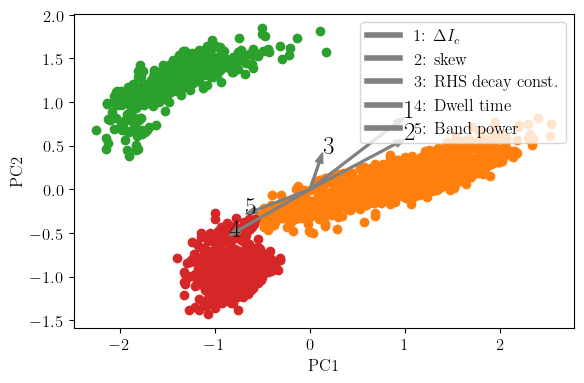

In [78]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Assuming 'pca', 'X_pca', 'X_pca_filtered', 'labels_agglo_filtered', 'color_and_label', and 'features_names' are defined

# Preparation steps (x, y, filtering, etc.) remain the same
x_filtered = X_pca_filtered[:, 0]
y_filtered = X_pca_filtered[:, 1]

# Calculate feature importances for the first two PCs
feature_importances = np.sqrt(np.sum(pca.components_[:2, :]**2, axis=0))

# Exclude specific feature by name
exclude_feature_name = "peak_lower_delta_I"
exclude_index = features_names.index(exclude_feature_name)
filtered_importances = np.delete(feature_importances, exclude_index)
filtered_feature_names = np.delete(np.array(features_names), exclude_index)

# Sort the features based on their importances
top_indices_sorted_by_importance = np.argsort(filtered_importances)[-6:-1][::-1]  # Get top 10, sorted by importance

# Plot setup
fig, ax = plt.subplots(figsize=(6,4))

for original_label, (color, new_label) in color_and_label.items():
    ax.scatter(x_filtered[labels_agglo_filtered == original_label], y_filtered[labels_agglo_filtered == original_label], 
               label=new_label, color=color, zorder=2)

# Create arrows for the top features, ensuring they are plotted in size order
feature_legend = {}
for i, idx in enumerate(top_indices_sorted_by_importance):
    component_magnitude = filtered_importances[idx]
    ax.arrow(0, 0, pca.components_[0, idx] * component_magnitude * 10, pca.components_[1, idx] * component_magnitude * 10, 
             color='grey', width=0.02, head_width=0.08, length_includes_head=True, zorder=5)
    ax.text(pca.components_[0, idx] * component_magnitude * 10, pca.components_[1, idx] * component_magnitude * 10, 
            f'{i+1}', color='black', fontsize=18, weight='bold', zorder=10)
    feature_legend[f'{i+1}'] = filtered_feature_names[idx]

# Creating a custom legend for the features
legend_elements = [Line2D([0], [0], color='grey', lw=4, label=f'{num}: {name}')
                   for num, name in feature_legend.items()]

# Create the legend and set its properties
ax.legend(handles=legend_elements, loc='upper right')

# Set labels and layout
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


Arrows not to scale ^^

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglomerative.fit_predict(X_pca)

# Calculate silhouette score for Agglomerative Clustering
silhouette_avg_agglo = silhouette_score(X_pca, labels_agglo)
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_avg_agglo}")

# Calculate centroids as the mean of the points in each cluster
centroids_agglo = np.array([X_pca[labels_agglo == i].mean(axis=0) for i in range(agglomerative.n_clusters)])


In [149]:
pca_all.explained_variance_

array([1.2352, 0.5732, 0.3121, ..., 0.0308, 0.0201, 0.0168])

In [155]:
sum(pca_all.explained_variance_ratio_[:3])

0.7814811296370299

Explained variance

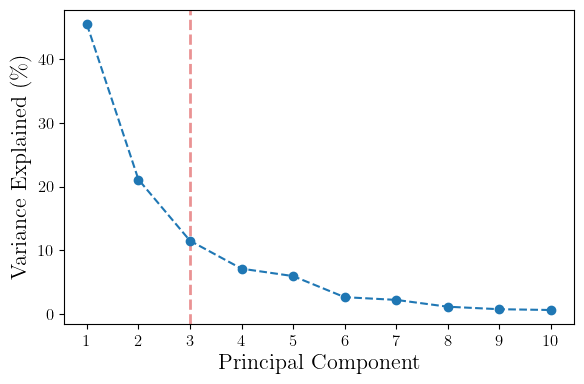

In [17]:
pca_all = PCA(n_components=10).fit(X_scaled)

plt.figure(figsize=(6, 4))

plt.axvline(x=3, color='tab:red', linestyle='--', linewidth=2, alpha  =0.5, label = "Optimal number of clusters")


plt.plot(range(1, len(pca_all.explained_variance_ratio_) + 1), pca_all.explained_variance_ratio_ * 100, marker='o', linestyle='--')
plt.xlabel('Principal Component', fontsize = 16)
plt.ylabel('Variance Explained ($\%$)', fontsize = 16)
plt.xticks(range(1, len(pca_all.explained_variance_ratio_) + 1))
plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/DNA_PCA_scree_bior22_6_4.png", dpi=300)
plt.show()

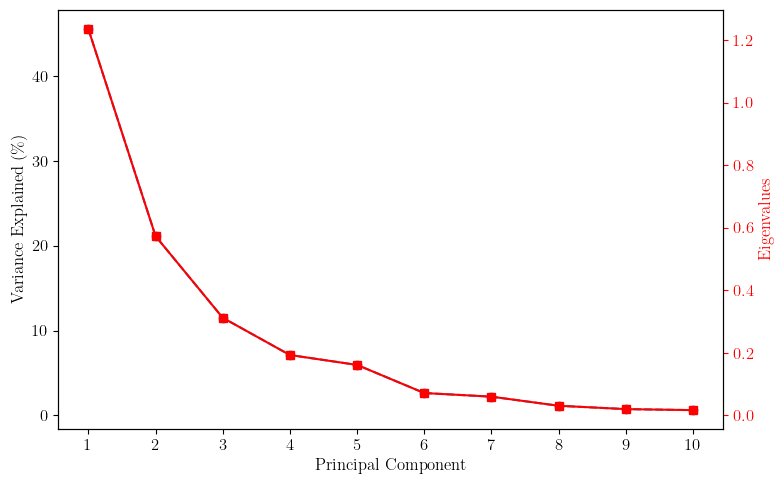

In [214]:
pca_all = PCA(n_components=10).fit(X_scaled)

# Plotting
plt.figure(figsize=(8, 5))

# Plot variance explained on the primary y-axis
plt.plot(range(1, len(pca_all.explained_variance_ratio_) + 1), pca_all.explained_variance_ratio_ * 100, marker='o', linestyle='--', label='Variance Explained (%)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained ($\%$)')
plt.xticks(range(1, len(pca_all.explained_variance_ratio_) + 1))

# Create a second y-axis for the eigenvalues
ax2 = plt.twinx()
ax2.plot(range(1, len(pca_all.explained_variance_) + 1), pca_all.explained_variance_, marker='s', linestyle='-', color='red', label='Eigenvalues')
ax2.set_ylabel('Eigenvalues', color='red')
# Change the color fof the axis ticks and labels to match the plot
ax2.tick_params(axis='y', colors='red')

plt.tight_layout()

# Save the figure
#plt.savefig("MSci_python_images/DNA_PCA_scree_bior22.png", dpi=300)

plt.show()

In [49]:
%matplotlib qt
%matplotlib inline

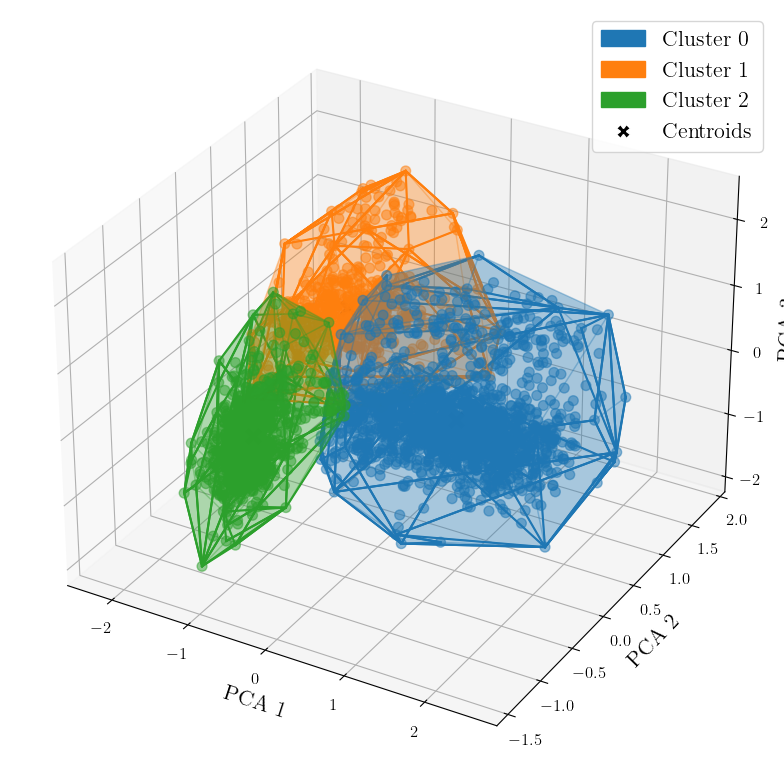

In [50]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Assuming X_scaled is your pre-processed data

# Perform PCA with 3 components
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

# Apply Agglomerative Clustering
agglomerative_3 = AgglomerativeClustering(n_clusters=3)
labels_agglo_3 = agglomerative_3.fit_predict(X_pca_3)

# Apply condition
condition = ~( (X_pca_3[:, 0] > 1) & (X_pca_3[:, 1] > 1.5) )
X_pca_3 = X_pca_3[condition]
labels_agglo_3 = labels_agglo_3[condition]

# Calculate centroids manually for each cluster
centroids_agglo_3 = np.array([X_pca_3[labels_agglo_3 == i].mean(axis=0) for i in range(agglomerative_3.n_clusters)])

# Colors for clusters
colors = ["tab:blue", "tab:green", "tab:orange"]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting clusters and centroids
for label, color in enumerate(colors):
    ds = X_pca_3[labels_agglo_3 == label]
    ax.scatter(ds[:, 0], ds[:, 1], ds[:, 2], s=50, color=color, alpha=0.5, label=f'Cluster {label}')

    # Compute and plot the convex hull
    if len(ds) > 3:  # ConvexHull needs at least 4 points in 3D
        hull = ConvexHull(ds)
        # Plot the polygons of the convex hull
        for simplex in hull.simplices:
            ax.plot3D(ds[simplex, 0], ds[simplex, 1], ds[simplex, 2], color=color)

        # Fill the convex hull with a transparent color
        hull_faces = Poly3DCollection([ds[hull.simplices[j]] for j in range(len(hull.simplices))], alpha=0.2, color=color)
        ax.add_collection3d(hull_faces)

# Plot centroids for 3D using the same color as their cluster
for label, color in enumerate(colors):
    centroid = centroids_agglo_3[label]
    ax.scatter(centroid[0], centroid[1], centroid[2], color="k", marker='X', s=200, edgecolor='w')

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:olive", "tab:cyan"]
legend_handles_3 = [Patch(color=color, label=f'Cluster {i}') for i, color in enumerate(colors[:n_clusters])]
legend_handles_3.append(Line2D([0], [0], marker='X', color='w', label='Centroids', markerfacecolor='k', markersize=10))
plt.legend(handles=legend_handles_3, loc="upper right", fontsize = 16)


ax.set_xlabel('PCA 1', fontsize = 16)
ax.set_ylabel('PCA 2', fontsize = 16)
ax.set_zlabel('PCA 3', fontsize = 16)
#plt.legend(loc="upper right", title="Clusters")
plt.tight_layout()
plt.show()

In [307]:
centroids_original_space_3 = pca_3.inverse_transform(centroids_agglo_3)
centroids_unscaled_3 = scaler.inverse_transform(centroids_original_space_3)

In [308]:
centroids_unscaled_3

array([[    222.6564,       0.0002,       2.5149, ..., 1829371.567 ,
             -1.1849,       4.3264],
       [    147.9203,       0.0003,       1.667 , ..., 1277030.3298,
              1.6654,       2.0328],
       [    182.0285,       0.0003,       1.8751, ..., 1379483.6951,
              1.2899,       2.3548]])